**notebook version**: `3` (4 Jul 2024)  
**new in this version**: added check if downloaded data is indeed in 30MIN time resolution

- This notebook can be used to download data from the database `InfluxDB`
- Data are stored to a `.csv` file in this folder

</br>

# **Auto-settings**

## Data settings

In [1]:
DIRCONF = r'F:\Sync\luhk_work\20 - CODING\22 - POET\configs'
# DIRCONF = r'P:\Flux\RDS_calculations\_scripts\_configs\configs'  # Folder with configuration files: needed e.g. for connection to database
TIMEZONE_OFFSET_TO_UTC_HOURS = 1  # Timezone, e.g. "1" is translated to timezone "UTC+01:00" (CET, winter time)
REQUIRED_TIME_RESOLUTION = '30min'  # 30MIN time resolution

## Imports

In [2]:
import importlib.metadata
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from diive.core.io.files import save_parquet

sns.set_theme('notebook')
from diive.core.plotting.timeseries import TimeSeries
from dbc_influxdb import dbcInflux
from diive.core.plotting.heatmap_datetime import HeatmapDateTime
from diive.core.times.times import TimestampSanitizer
from diive.pkgs.createvar.potentialradiation import potrad
from diive.pkgs.gapfilling.xgboost_ts import XGBoostTS
from diive.core.io.files import load_parquet
import warnings

warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")
version_dbc = importlib.metadata.version("dbc_influxdb")
print(f"dbc-influxdb version: v{version_dbc}")
dbc = dbcInflux(dirconf=DIRCONF)  # Connect to database

diive version: v0.80.0
dbc-influxdb version: v0.12.0
Reading configuration files was successful.
Connection to database works.


</br>

# **LOAD DATA** from files

In [3]:
filename_data_simple_2005_2023 = "15.1_CH-CHA_meteo6_2005-2023.parquet"
data_simple_2005_2023 = load_parquet(filepath=filename_data_simple_2005_2023)
data_simple_2005_2023

Loaded .parquet file 15.1_CH-CHA_meteo6_2005-2023.parquet (0.074 seconds). Detected time resolution of <30 * Minutes> / 30min 


G_GF1_0.03_1  LW_IN_T1_2_1  LW_OUT_T1_2_1  PA_GF1_0.9_1  FLAG_PA_GF1_0.9_1_ISFILLED  PPFD_IN_T1_2_2  PREC_RAIN_TOT_GF1_0.5_1  FLAG_PREC_RAIN_TOT_GF1_0.5_1_ISFILLED  RH_T1_2_1  FLAG_RH_T1_2_1_ISFILLED  SWC_GF1_0.05_1  SWC_GF1_0.15_1  SWC_GF1_0.75_1  SW_IN_T1_2_1  FLAG_SW_IN_T1_2_1_ISFILLED  SW_OUT_T1_2_1  TA_T1_2_1  FLAG_TA_T1_2_1_ISFILLED  TS_GF1_0.04_1  TS_GF1_0.15_1  TS_GF1_0.4_1
TIMESTAMP_MIDDLE                                                                                                                                                                                                                                                                                                                                                                                                     
2005-01-01 00:15:00           NaN           NaN            NaN    978.100000                         1.0             NaN                      0.0                                    1.0  85.400000                      1.0             NaN             NaN             NaN           3.0                         3.0            NaN   1.566667                      3.0            NaN            NaN           NaN
2005-01-01 00:45:00           NaN           NaN            NaN    977.933333                         1.0             NaN                      0.0                                    1.0  85.700000                      1.0             NaN             NaN             NaN           3.0                         3.0            NaN   1.533333                      3.0            NaN            NaN           NaN
2005-01-01 01:15:00           NaN           NaN            NaN    977.900000                         1.0             NaN                      0.1                                    1.0  86.600000                      1.0             NaN             NaN             NaN           3.0                         3.0            NaN   1.566667                      3.0            NaN            NaN           NaN
2005-01-01 01:45:00           NaN           NaN            NaN    977.833333                         1.0             NaN                      0.0                                    1.0  89.600000                      1.0             NaN             NaN             NaN           3.0                         3.0            NaN   1.566667                      3.0            NaN            NaN           NaN
2005-01-01 02:15:00           NaN           NaN            NaN    977.833333                         1.0             NaN                      0.1                                    1.0  91.433333                      1.0             NaN             NaN             NaN           0.0                         3.0            NaN   1.500000                      3.0            NaN            NaN           NaN
...                           ...           ...            ...           ...                         ...             ...                      ...                                    ...        ...                      ...             ...             ...             ...           ...                         ...            ...        ...                      ...            ...            ...           ...
2023-12-31 21:45:00           NaN    327.407107            NaN    964.969617                         NaN             0.0                      NaN                                    NaN  99.461884                      NaN             NaN             NaN             NaN           0.0                         NaN            NaN   1.540578                      NaN            NaN            NaN           NaN
2023-12-31 22:15:00           NaN    327.958383            NaN    965.049553                         NaN             0.0                      NaN                                    NaN  98.875075                      NaN             NaN             NaN             NaN           0.0                         NaN            NaN   2.051889                      NaN      

</br>

</br>

## Plot

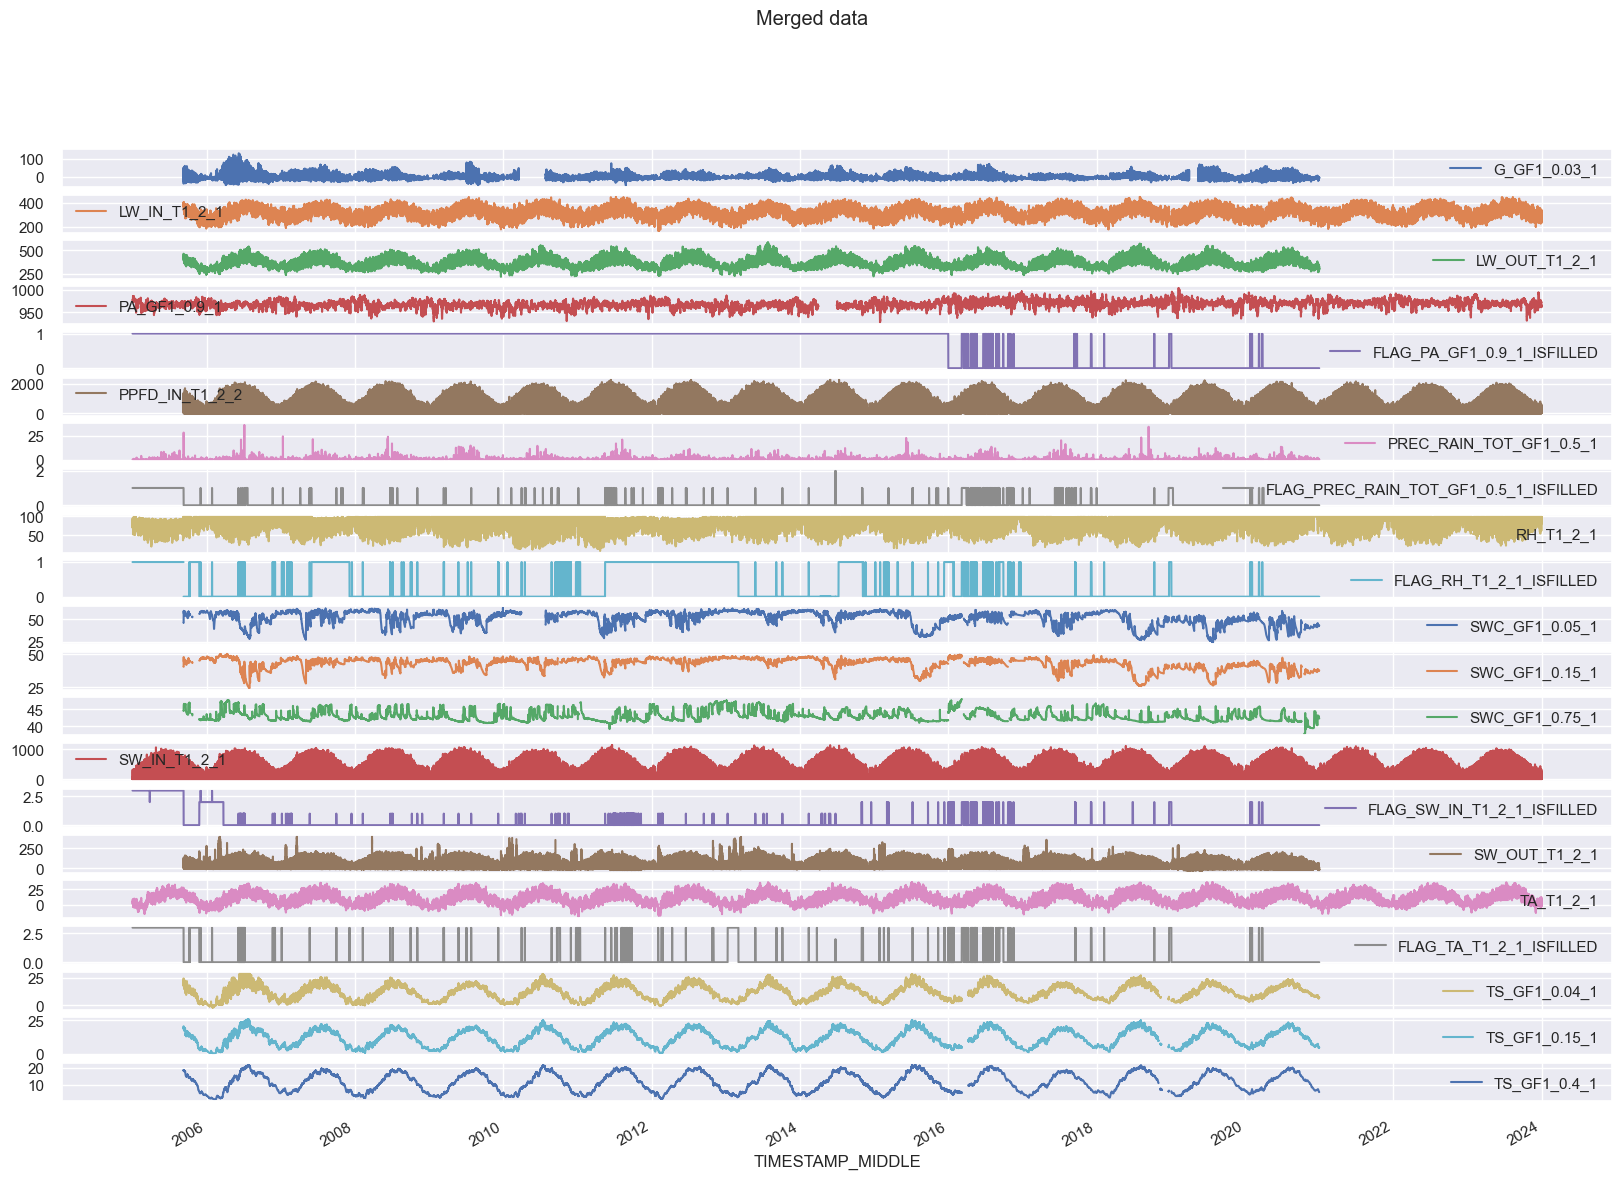

In [4]:
data_simple_2005_2023.plot(subplots=True, x_compat=True, title="Merged data", figsize=(20, 14));

# **Gap-filling**

## SW_IN

In [6]:
_df = pd.DataFrame()
_df['SW_IN_T1_2_1'] = data_simple_2005_2023[['SW_IN_T1_2_1']].copy()
_df['SW_IN_POT'] = potrad(timestamp_index=_df.index,
                          lat=47.210227,  # CH-CHA
                          lon=8.410645,  # CH-CHA
                          utc_offset=1)
_df

SW_IN_T1_2_1  SW_IN_POT
TIMESTAMP_MIDDLE                            
2005-01-01 00:15:00           3.0        0.0
2005-01-01 00:45:00           3.0        0.0
2005-01-01 01:15:00           3.0        0.0
2005-01-01 01:45:00           3.0        0.0
2005-01-01 02:15:00           0.0        0.0
...                           ...        ...
2023-12-31 21:45:00           0.0        0.0
2023-12-31 22:15:00           0.0        0.0
2023-12-31 22:45:00           0.0        0.0
2023-12-31 23:15:00           0.0        0.0
2023-12-31 23:45:00           0.0        0.0

[333072 rows x 2 columns]

### Set nighttime data to zero

In [21]:
# Detect nighttime
from diive.pkgs.createvar.daynightflag import DaytimeNighttimeFlag
dnf = DaytimeNighttimeFlag(
    timestamp_index=_df.index,
    nighttime_threshold=0.001,
    lat=47.210227,  # CH-CHA
    lon=8.410645,  # CH-CHA
    utc_offset=1,
    nighttime_threshold=0.001)
nighttimeflag = dnf.get_nighttime_flag()
nighttime_ix = nighttimeflag == 1

Some nighttime data is above or below zero:

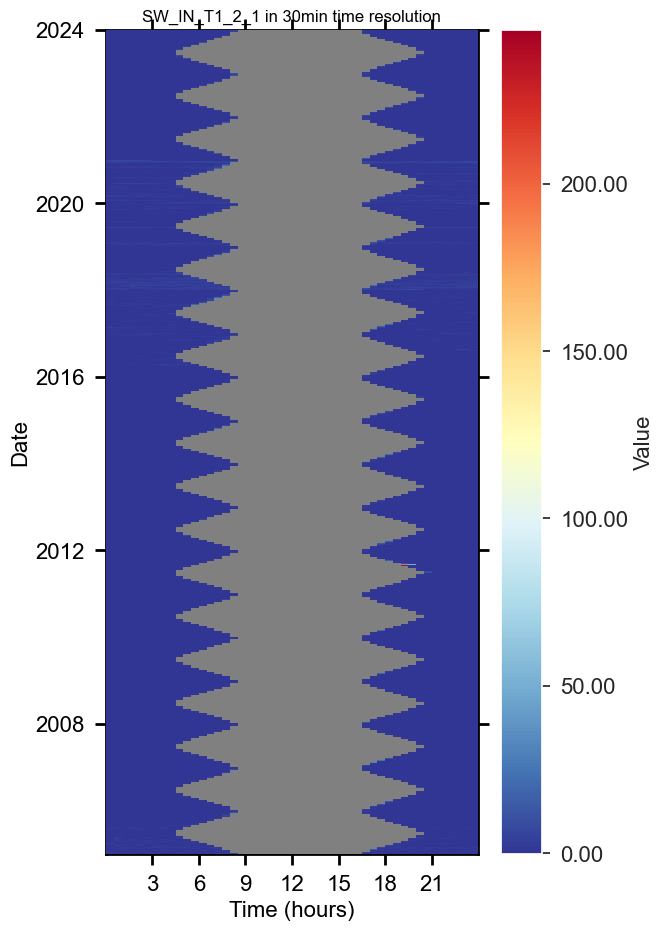

In [27]:
HeatmapDateTime(_df.loc[nighttime_ix, 'SW_IN_T1_2_1']).plot()

In [28]:
_df.loc[nighttime_ix, 'SW_IN_T1_2_1'].describe()

count    166492.000000
mean          0.291969
std           1.801247
min          -0.158850
25%           0.000000
50%           0.000000
75%           0.000000
max         246.000000
Name: SW_IN_T1_2_1, dtype: float64

In [29]:
_df.loc[nighttime_ix, 'SW_IN_T1_2_1'] = 0
_df.loc[nighttime_ix, 'SW_IN_T1_2_1'].describe()

count    166492.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: SW_IN_T1_2_1, dtype: float64

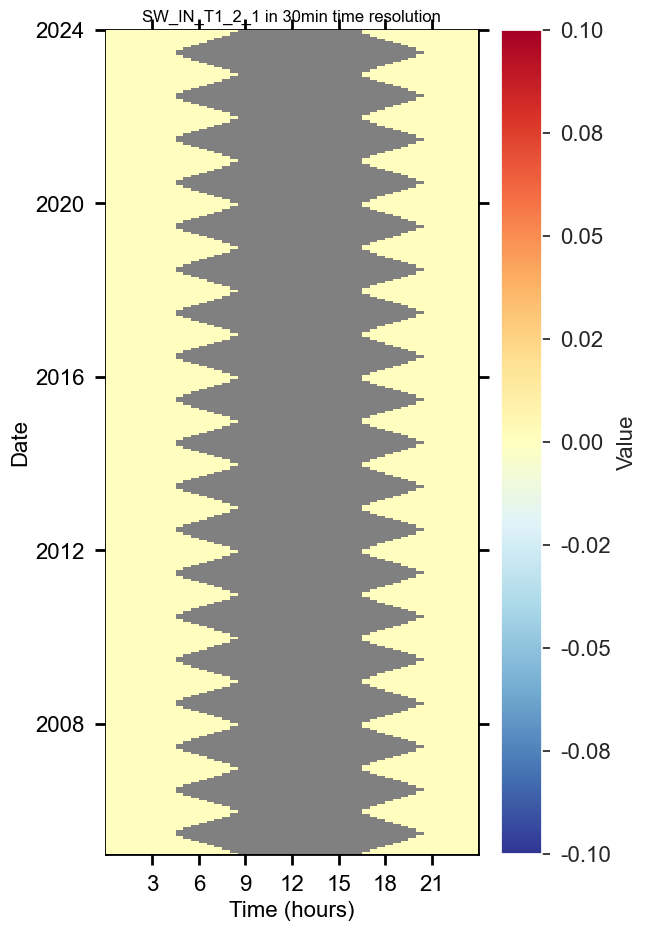

In [30]:
HeatmapDateTime(_df.loc[nighttime_ix, 'SW_IN_T1_2_1']).plot()

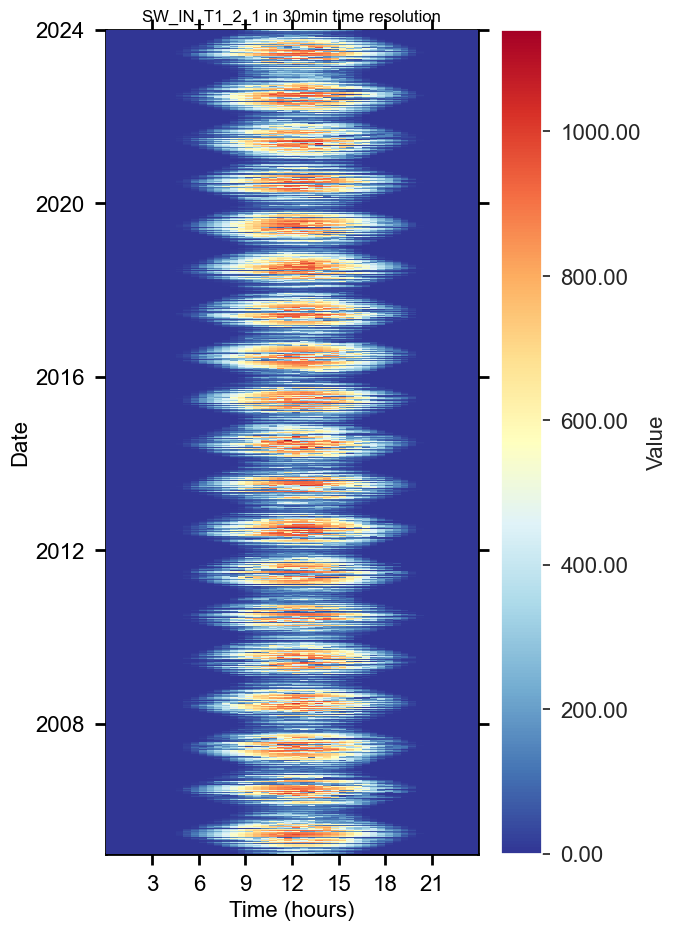

In [31]:
HeatmapDateTime(_df['SW_IN_T1_2_1']).plot()

### Fill

In [35]:
xgb = XGBoostTS(
    input_df=_df,
    target_col='SW_IN_T1_2_1',
    perm_n_repeats=10,
    include_timestamp_as_features=True,
    add_continuous_record_number=True,
    n_estimators=1000,
    random_state=42,
    early_stopping_rounds=50,
    n_jobs=-1
)


Adding new data columns ...
++ Added new columns with timestamp info: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 
++ Added new column .RECORDNUMBER with record numbers from 1 to 333072.


In [36]:
xgb.reduce_features()
xgb.report_feature_reduction()


Feature reduction based on permutation importance ...
[0]	validation_0-rmse:185.49395	validation_1-rmse:185.49395
[1]	validation_0-rmse:154.16717	validation_1-rmse:154.16717
[2]	validation_0-rmse:136.10672	validation_1-rmse:136.10672
[3]	validation_0-rmse:126.14502	validation_1-rmse:126.14502
[4]	validation_0-rmse:120.87394	validation_1-rmse:120.87394
[5]	validation_0-rmse:117.95678	validation_1-rmse:117.95678
[6]	validation_0-rmse:116.41012	validation_1-rmse:116.41012
[7]	validation_0-rmse:115.35704	validation_1-rmse:115.35704
[8]	validation_0-rmse:114.68347	validation_1-rmse:114.68347
[9]	validation_0-rmse:114.23230	validation_1-rmse:114.23230
[10]	validation_0-rmse:113.89508	validation_1-rmse:113.89508
[11]	validation_0-rmse:113.53875	validation_1-rmse:113.53875
[12]	validation_0-rmse:113.27498	validation_1-rmse:113.27498
[13]	validation_0-rmse:112.88276	validation_1-rmse:112.88276
[14]	validation_0-rmse:112.40555	validation_1-rmse:112.40555
[15]	validation_0-rmse:112.08745	validat

In [37]:
xgb.trainmodel(showplot_scores=False, showplot_importance=False)
xgb.report_traintest()


Training final model ...
>>> Training model <class 'xgboost.sklearn.XGBRegressor'> based on data between 2005-01-01 00:45:00 and 2023-12-31 23:15:00 ...
>>> Fitting model to training data ...
[0]	validation_0-rmse:185.51265	validation_1-rmse:184.55367
[1]	validation_0-rmse:154.20612	validation_1-rmse:153.87940
[2]	validation_0-rmse:136.13425	validation_1-rmse:136.37697
[3]	validation_0-rmse:126.15071	validation_1-rmse:126.91375
[4]	validation_0-rmse:120.87401	validation_1-rmse:122.03722
[5]	validation_0-rmse:118.03067	validation_1-rmse:119.50354
[6]	validation_0-rmse:116.35204	validation_1-rmse:118.05505
[7]	validation_0-rmse:115.43509	validation_1-rmse:117.29871
[8]	validation_0-rmse:114.87904	validation_1-rmse:116.85301
[9]	validation_0-rmse:114.46997	validation_1-rmse:116.50067
[10]	validation_0-rmse:113.76542	validation_1-rmse:115.93147
[11]	validation_0-rmse:113.34861	validation_1-rmse:115.65657
[12]	validation_0-rmse:113.05430	validation_1-rmse:115.41132
[13]	validation_0-rmse:1

In [38]:
xgb.fillgaps(showplot_scores=False, showplot_importance=False)
xgb.report_gapfilling()


Gap-filling using final model ...
>>> Using final model on all data to predict target SW_IN_T1_2_1 ...
>>> Using final model on all data to calculate permutation importance ...
>>> Calculating prediction scores based on all data predicting SW_IN_T1_2_1 ...
>>> Predicting target SW_IN_T1_2_1 where all features are available ... predicted 333072 records.
>>> Collecting results for final model ...
>>> Filling 12 missing records in target with predictions from final model ...
>>> Storing gap-filled time series in variable SW_IN_T1_2_1_gfXG ...
>>> Restoring original timestamp in results ...
>>> Combining predictions from full model and fallback model ...

GAP-FILLING RESULTS

Model scores and feature importances were calculated from high-quality predicted targets (12 values, SW_IN_T1_2_1_gfXG where flag=1) in comparison to observed targets (333060 values, SW_IN_T1_2_1).

## TARGET
- first timestamp:  2005-01-01 00:15:00
- last timestamp:  2023-12-31 23:45:00
- potential number of values: 

### Results

In [44]:
results = xgb.gapfilling_df_
results

.PREDICTIONS_FULLMODEL  SW_IN_T1_2_1  .GAP_PREDICTIONS  FLAG_SW_IN_T1_2_1_gfXG_ISFILLED  SW_IN_T1_2_1_gfXG .PREDICTIONS_FALLBACK  .GAPFILLED_CUMULATIVE  .PREDICTIONS
TIMESTAMP_MIDDLE                                                                                                                                                                          
2005-01-01 00:15:00                2.456964           0.0               NaN                                0                0.0                  None           0.000000e+00      2.456964
2005-01-01 00:45:00                2.456964           0.0               NaN                                0                0.0                  None           0.000000e+00      2.456964
2005-01-01 01:15:00                2.456964           0.0               NaN                                0                0.0                  None           0.000000e+00      2.456964
2005-01-01 01:45:00                2.456964           0.0               NaN                                0                0.0                  None           0.000000e+00      2.456964
2005-01-01 02:15:00                2.456964           0.0               NaN                                0                0.0                  None           0.000000e+00      2.456964
...                                     ...           ...               ...                              ...                ...                   ...                    ...           ...
2023-12-31 21:45:00                0.920065           0.0               NaN                                0                0.0                  None           4.760115e+07      0.920065
2023-12-31 22:15:00                0.920065           0.0               NaN                                0                0.0                  None           4.760115e+07      0.920065
2023-12-31 22:45:00                0.920065           0.0               NaN                                0                0.0                  None           4.760115e+07      0.920065
2023-12-31 23:15:00                0.920065           0.0               NaN                                0                0.0                  None           4.760115e+07      0.920065
2023-12-31 23:45:00                0.920065           0.0               NaN                                0                0.0                  None           4.760115e+07      0.920065

[333072 rows x 8 columns]

### Add to data

In [52]:
# Combine data
data_simple_2005_2023['SW_IN_T1_2_1'] = results['SW_IN_T1_2_1_gfXG'].copy()
data_simple_2005_2023['SW_IN_T1_2_1']

TIMESTAMP_MIDDLE
2005-01-01 00:15:00    0.0
2005-01-01 00:45:00    0.0
2005-01-01 01:15:00    0.0
2005-01-01 01:45:00    0.0
2005-01-01 02:15:00    0.0
                      ... 
2023-12-31 21:45:00    0.0
2023-12-31 22:15:00    0.0
2023-12-31 22:45:00    0.0
2023-12-31 23:15:00    0.0
2023-12-31 23:45:00    0.0
Freq: 30min, Name: SW_IN_T1_2_1, Length: 333072, dtype: float64

In [53]:
# Combine flags
data_simple_2005_2023['FLAG_SW_IN_T1_2_1_ISFILLED'] = data_simple_2005_2023['FLAG_SW_IN_T1_2_1_ISFILLED'].combine_first(results['FLAG_SW_IN_T1_2_1_gfXG_ISFILLED'])
data_simple_2005_2023['FLAG_SW_IN_T1_2_1_ISFILLED']

TIMESTAMP_MIDDLE
2005-01-01 00:15:00    3.0
2005-01-01 00:45:00    3.0
2005-01-01 01:15:00    3.0
2005-01-01 01:45:00    3.0
2005-01-01 02:15:00    3.0
                      ... 
2023-12-31 21:45:00    0.0
2023-12-31 22:15:00    0.0
2023-12-31 22:45:00    0.0
2023-12-31 23:15:00    0.0
2023-12-31 23:45:00    0.0
Freq: 30min, Name: FLAG_SW_IN_T1_2_1_ISFILLED, Length: 333072, dtype: float64

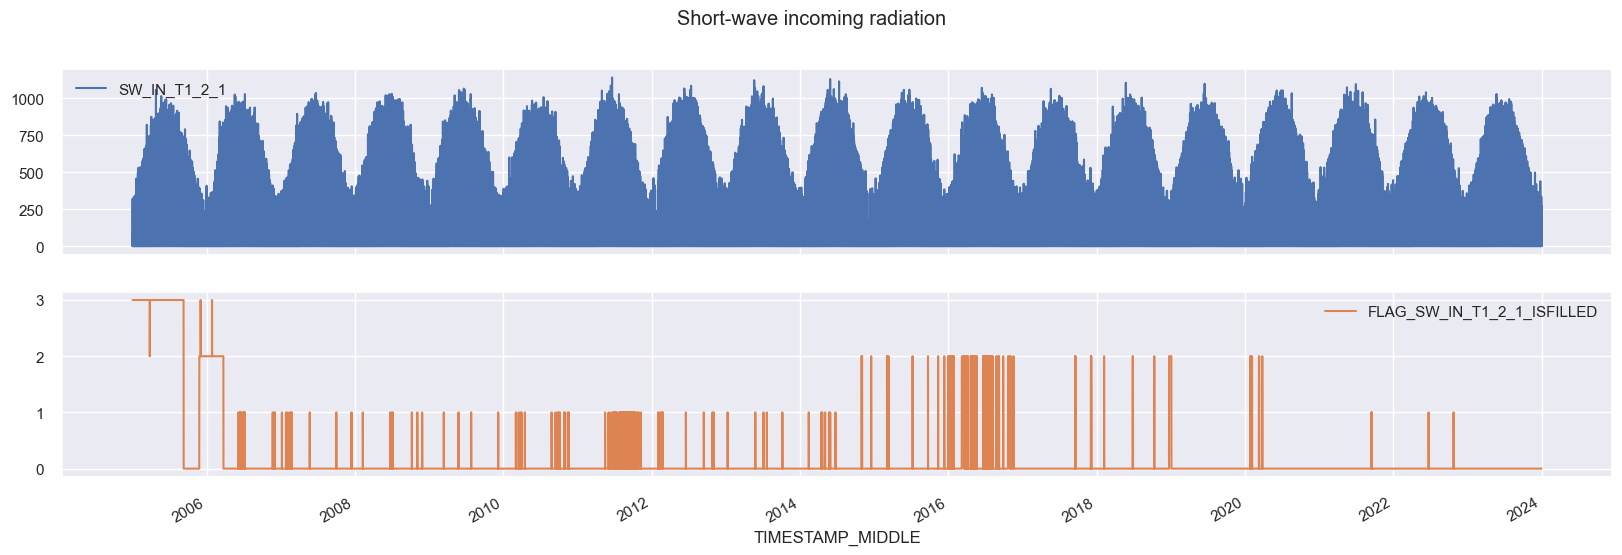

In [57]:
title = "Short-wave incoming radiation"
data_simple_2005_2023[['SW_IN_T1_2_1', 'FLAG_SW_IN_T1_2_1_ISFILLED']].plot(x_compat=True, title=title, subplots=True, figsize=(20, 6));

</br>

## TA

In [60]:
_df = pd.DataFrame()
_df['SW_IN_T1_2_1'] = data_simple_2005_2023['SW_IN_T1_2_1'].copy()
_df['TA_T1_2_1'] = data_simple_2005_2023['TA_T1_2_1'].copy()
_df

SW_IN_T1_2_1  TA_T1_2_1
TIMESTAMP_MIDDLE                            
2005-01-01 00:15:00           0.0   1.566667
2005-01-01 00:45:00           0.0   1.533333
2005-01-01 01:15:00           0.0   1.566667
2005-01-01 01:45:00           0.0   1.566667
2005-01-01 02:15:00           0.0   1.500000
...                           ...        ...
2023-12-31 21:45:00           0.0   1.540578
2023-12-31 22:15:00           0.0   2.051889
2023-12-31 22:45:00           0.0   2.223067
2023-12-31 23:15:00           0.0   2.206628
2023-12-31 23:45:00           0.0   2.298628

[333072 rows x 2 columns]

### Fill

In [61]:
xgb = XGBoostTS(
    input_df=_df,
    target_col='TA_T1_2_1',
    perm_n_repeats=10,
    include_timestamp_as_features=True,
    add_continuous_record_number=True,
    n_estimators=1000,
    random_state=42,
    early_stopping_rounds=50,
    n_jobs=-1
)


Adding new data columns ...
++ Added new columns with timestamp info: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 
++ Added new column .RECORDNUMBER with record numbers from 1 to 333072.


In [62]:
xgb.reduce_features()
xgb.report_feature_reduction()


Feature reduction based on permutation importance ...
[0]	validation_0-rmse:6.58413	validation_1-rmse:6.58413
[1]	validation_0-rmse:5.35907	validation_1-rmse:5.35907
[2]	validation_0-rmse:4.59715	validation_1-rmse:4.59715
[3]	validation_0-rmse:4.14176	validation_1-rmse:4.14176
[4]	validation_0-rmse:3.84356	validation_1-rmse:3.84356
[5]	validation_0-rmse:3.66885	validation_1-rmse:3.66885
[6]	validation_0-rmse:3.55668	validation_1-rmse:3.55668
[7]	validation_0-rmse:3.49288	validation_1-rmse:3.49288
[8]	validation_0-rmse:3.42906	validation_1-rmse:3.42906
[9]	validation_0-rmse:3.39616	validation_1-rmse:3.39616
[10]	validation_0-rmse:3.36684	validation_1-rmse:3.36684
[11]	validation_0-rmse:3.34785	validation_1-rmse:3.34785
[12]	validation_0-rmse:3.31359	validation_1-rmse:3.31359
[13]	validation_0-rmse:3.29440	validation_1-rmse:3.29440
[14]	validation_0-rmse:3.25757	validation_1-rmse:3.25757
[15]	validation_0-rmse:3.24521	validation_1-rmse:3.24521
[16]	validation_0-rmse:3.22555	validation_1

In [63]:
xgb.trainmodel(showplot_scores=False, showplot_importance=False)
xgb.report_traintest()


Training final model ...
>>> Training model <class 'xgboost.sklearn.XGBRegressor'> based on data between 2005-01-01 00:45:00 and 2023-12-31 23:15:00 ...
>>> Fitting model to training data ...
[0]	validation_0-rmse:6.58413	validation_1-rmse:6.59367
[1]	validation_0-rmse:5.35907	validation_1-rmse:5.37122
[2]	validation_0-rmse:4.59715	validation_1-rmse:4.61231
[3]	validation_0-rmse:4.14176	validation_1-rmse:4.15937
[4]	validation_0-rmse:3.84356	validation_1-rmse:3.86257
[5]	validation_0-rmse:3.66885	validation_1-rmse:3.68828
[6]	validation_0-rmse:3.55668	validation_1-rmse:3.57770
[7]	validation_0-rmse:3.49288	validation_1-rmse:3.51518
[8]	validation_0-rmse:3.42906	validation_1-rmse:3.45296
[9]	validation_0-rmse:3.39616	validation_1-rmse:3.42135
[10]	validation_0-rmse:3.36684	validation_1-rmse:3.39205
[11]	validation_0-rmse:3.34785	validation_1-rmse:3.37327
[12]	validation_0-rmse:3.31359	validation_1-rmse:3.33843
[13]	validation_0-rmse:3.29440	validation_1-rmse:3.31980
[14]	validation_0-r

In [64]:
xgb.fillgaps(showplot_scores=False, showplot_importance=False)
xgb.report_gapfilling()


Gap-filling using final model ...
>>> Using final model on all data to predict target TA_T1_2_1 ...
>>> Using final model on all data to calculate permutation importance ...
>>> Calculating prediction scores based on all data predicting TA_T1_2_1 ...
>>> Predicting target TA_T1_2_1 where all features are available ... predicted 333072 records.
>>> Collecting results for final model ...
>>> Filling 168 missing records in target with predictions from final model ...
>>> Storing gap-filled time series in variable TA_T1_2_1_gfXG ...
>>> Restoring original timestamp in results ...
>>> Combining predictions from full model and fallback model ...

GAP-FILLING RESULTS

Model scores and feature importances were calculated from high-quality predicted targets (168 values, TA_T1_2_1_gfXG where flag=1) in comparison to observed targets (332904 values, TA_T1_2_1).

## TARGET
- first timestamp:  2005-01-01 00:15:00
- last timestamp:  2023-12-31 23:45:00
- potential number of values: 333072 values)
-

### Results

In [65]:
results = xgb.gapfilling_df_
results

.PREDICTIONS_FULLMODEL  TA_T1_2_1  .GAP_PREDICTIONS  FLAG_TA_T1_2_1_gfXG_ISFILLED  TA_T1_2_1_gfXG .PREDICTIONS_FALLBACK  .GAPFILLED_CUMULATIVE  .PREDICTIONS
TIMESTAMP_MIDDLE                                                                                                                                                                 
2005-01-01 00:15:00                3.270065   1.566667               NaN                             0        1.566667                  None           1.566667e+00      3.270065
2005-01-01 00:45:00                3.270065   1.533333               NaN                             0        1.533333                  None           3.100000e+00      3.270065
2005-01-01 01:15:00                3.602876   1.566667               NaN                             0        1.566667                  None           4.666667e+00      3.602876
2005-01-01 01:45:00                3.602876   1.566667               NaN                             0        1.566667                  None           6.233333e+00      3.602876
2005-01-01 02:15:00                3.397877   1.500000               NaN                             0        1.500000                  None           7.733333e+00      3.397877
...                                     ...        ...               ...                           ...             ...                   ...                    ...           ...
2023-12-31 21:45:00                0.676866   1.540578               NaN                             0        1.540578                  None           3.315909e+06      0.676866
2023-12-31 22:15:00                0.240295   2.051889               NaN                             0        2.051889                  None           3.315911e+06      0.240295
2023-12-31 22:45:00                0.240295   2.223067               NaN                             0        2.223067                  None           3.315913e+06      0.240295
2023-12-31 23:15:00               -0.221049   2.206628               NaN                             0        2.206628                  None           3.315915e+06     -0.221049
2023-12-31 23:45:00               -0.221049   2.298628               NaN                             0        2.298628                  None           3.315918e+06     -0.221049

[333072 rows x 8 columns]

### Add to data

In [66]:
# Combine data
data_simple_2005_2023['TA_T1_2_1'] = results['TA_T1_2_1_gfXG'].copy()
data_simple_2005_2023['TA_T1_2_1']

TIMESTAMP_MIDDLE
2005-01-01 00:15:00    1.566667
2005-01-01 00:45:00    1.533333
2005-01-01 01:15:00    1.566667
2005-01-01 01:45:00    1.566667
2005-01-01 02:15:00    1.500000
                         ...   
2023-12-31 21:45:00    1.540578
2023-12-31 22:15:00    2.051889
2023-12-31 22:45:00    2.223067
2023-12-31 23:15:00    2.206628
2023-12-31 23:45:00    2.298628
Freq: 30min, Name: TA_T1_2_1, Length: 333072, dtype: float64

In [67]:
# Combine flags
data_simple_2005_2023['FLAG_TA_T1_2_1_ISFILLED'] = data_simple_2005_2023['FLAG_TA_T1_2_1_ISFILLED'].combine_first(results['FLAG_TA_T1_2_1_gfXG_ISFILLED'])
data_simple_2005_2023['FLAG_TA_T1_2_1_ISFILLED']

TIMESTAMP_MIDDLE
2005-01-01 00:15:00    3.0
2005-01-01 00:45:00    3.0
2005-01-01 01:15:00    3.0
2005-01-01 01:45:00    3.0
2005-01-01 02:15:00    3.0
                      ... 
2023-12-31 21:45:00    0.0
2023-12-31 22:15:00    0.0
2023-12-31 22:45:00    0.0
2023-12-31 23:15:00    0.0
2023-12-31 23:45:00    0.0
Freq: 30min, Name: FLAG_TA_T1_2_1_ISFILLED, Length: 333072, dtype: float64

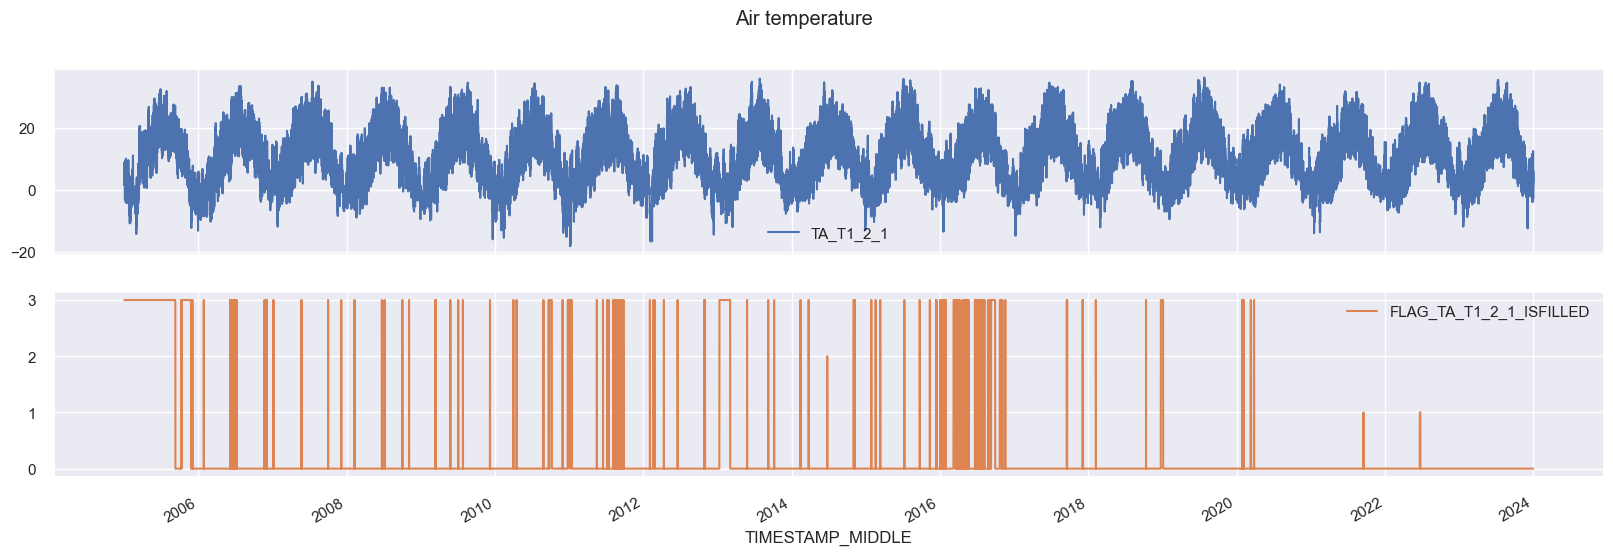

In [68]:
title = "Air temperature"
data_simple_2005_2023[['TA_T1_2_1', 'FLAG_TA_T1_2_1_ISFILLED']].plot(x_compat=True, title=title, subplots=True, figsize=(20, 6));

</br>

## PPFD

In [76]:
_df = pd.DataFrame()
_df['PPFD_IN_T1_2_2'] = data_simple_2005_2023[['PPFD_IN_T1_2_2']].copy()
_df['SW_IN_T1_2_1'] = data_simple_2005_2023[['SW_IN_T1_2_1']].copy()
_df

PPFD_IN_T1_2_2  SW_IN_T1_2_1
TIMESTAMP_MIDDLE                                 
2005-01-01 00:15:00       -1.545202           0.0
2005-01-01 00:45:00       -1.545202           0.0
2005-01-01 01:15:00       -1.545202           0.0
2005-01-01 01:45:00       -1.545202           0.0
2005-01-01 02:15:00       -1.545202           0.0
...                             ...           ...
2023-12-31 21:45:00        0.000000           0.0
2023-12-31 22:15:00        0.000000           0.0
2023-12-31 22:45:00        0.000000           0.0
2023-12-31 23:15:00        0.000000           0.0
2023-12-31 23:45:00        0.000000           0.0

[333072 rows x 2 columns]

### Set nighttime data to zero

In [78]:
# Detect nighttime
from diive.pkgs.createvar.daynightflag import DaytimeNighttimeFlag
dnf = DaytimeNighttimeFlag(
    timestamp_index=_df.index,    
    lat=47.210227,  # CH-CHA
    lon=8.410645,  # CH-CHA
    utc_offset=1,
    nighttime_threshold=0.001)
nighttimeflag = dnf.get_nighttime_flag()
nighttime_ix = nighttimeflag == 1

Some nighttime data is above or below zero:

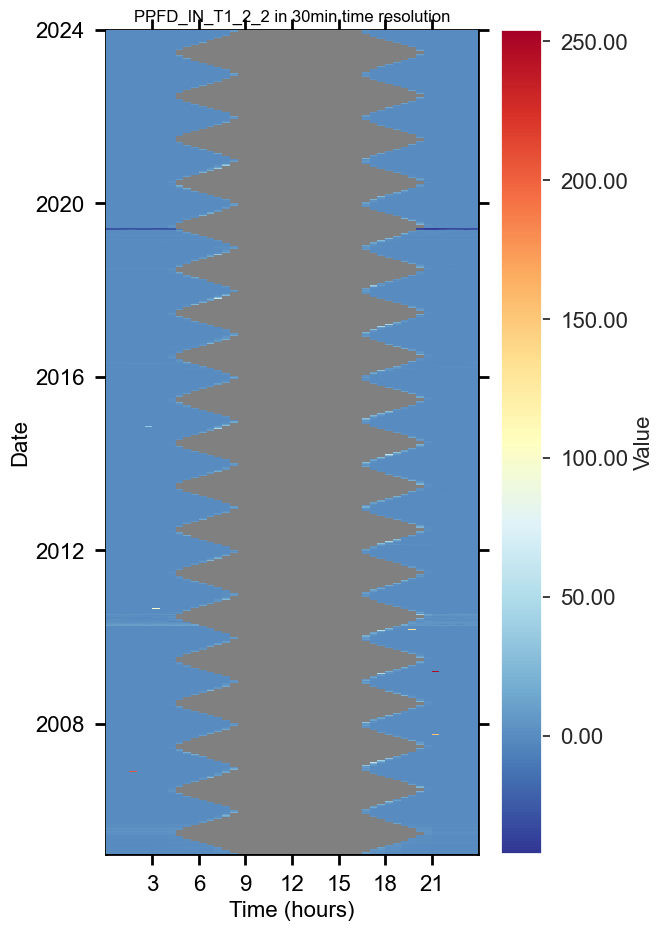

In [79]:
HeatmapDateTime(_df.loc[nighttime_ix, 'PPFD_IN_T1_2_2']).plot()

In [80]:
_df.loc[nighttime_ix, 'PPFD_IN_T1_2_2'].describe()

count    166492.000000
mean          0.375533
std           3.765490
min         -42.389820
25%          -0.174810
50%           0.000000
75%           0.000000
max         254.000000
Name: PPFD_IN_T1_2_2, dtype: float64

In [81]:
_df.loc[nighttime_ix, 'PPFD_IN_T1_2_2'] = 0
_df.loc[nighttime_ix, 'PPFD_IN_T1_2_2'].describe()

count    166492.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: PPFD_IN_T1_2_2, dtype: float64

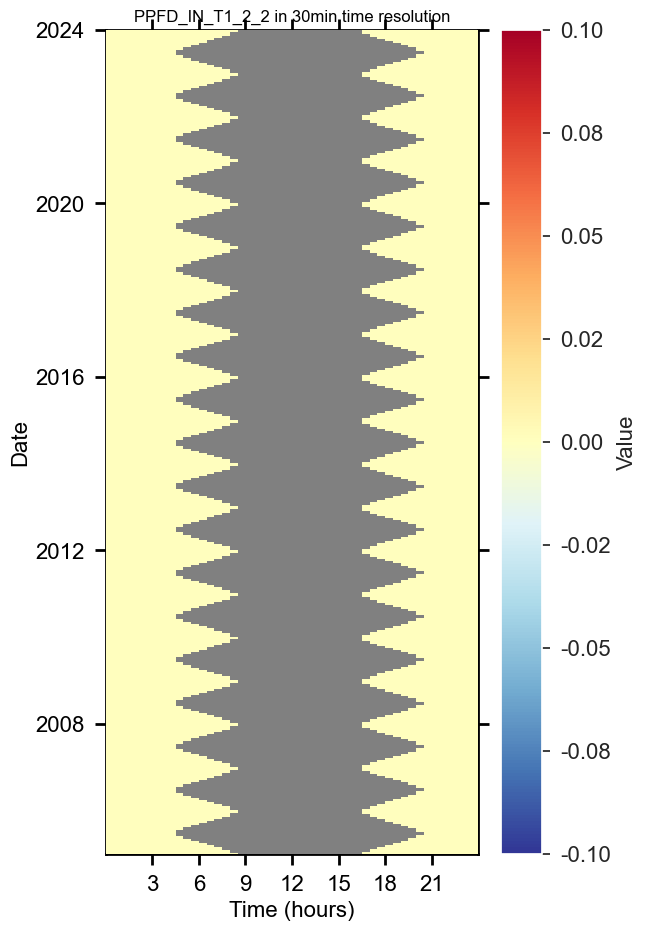

In [82]:
HeatmapDateTime(_df.loc[nighttime_ix, 'PPFD_IN_T1_2_2']).plot()

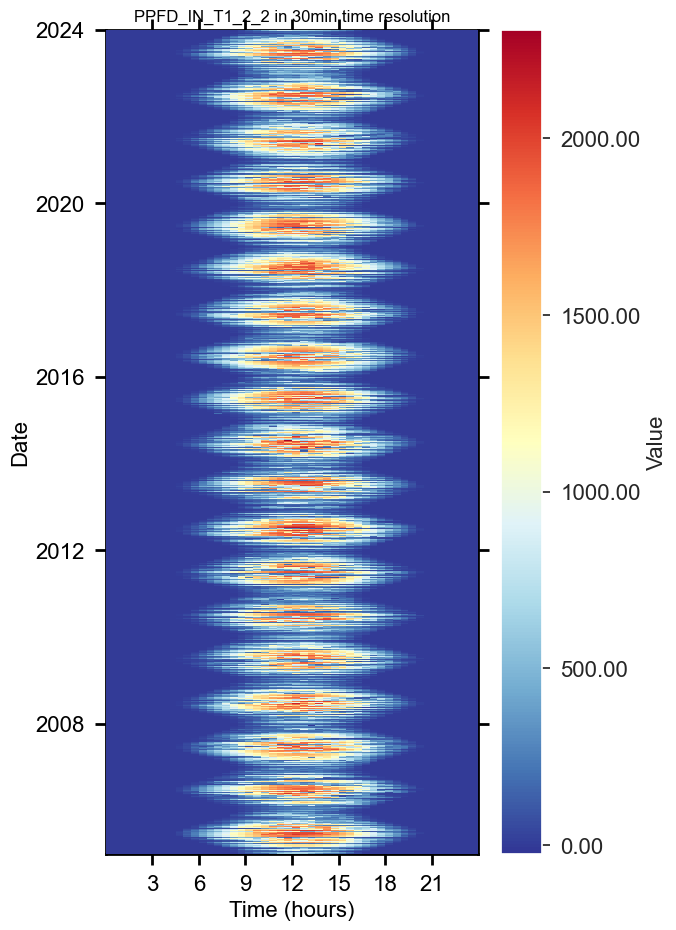

In [83]:
HeatmapDateTime(_df['PPFD_IN_T1_2_2']).plot()

### Fill

In [84]:
xgb = XGBoostTS(
    input_df=_df,
    target_col='PPFD_IN_T1_2_2',
    perm_n_repeats=10,
    include_timestamp_as_features=True,
    add_continuous_record_number=True,
    n_estimators=1000,
    random_state=42,
    early_stopping_rounds=50,
    n_jobs=-1
)


Adding new data columns ...
++ Added new columns with timestamp info: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 
++ Added new column .RECORDNUMBER with record numbers from 1 to 333072.


In [85]:
xgb.reduce_features()
xgb.report_feature_reduction()


Feature reduction based on permutation importance ...
[0]	validation_0-rmse:329.25407	validation_1-rmse:329.25407
[1]	validation_0-rmse:231.90477	validation_1-rmse:231.90477
[2]	validation_0-rmse:164.23055	validation_1-rmse:164.23055
[3]	validation_0-rmse:117.48548	validation_1-rmse:117.48548
[4]	validation_0-rmse:85.55554	validation_1-rmse:85.55554
[5]	validation_0-rmse:64.25310	validation_1-rmse:64.25310
[6]	validation_0-rmse:50.47376	validation_1-rmse:50.47376
[7]	validation_0-rmse:41.88957	validation_1-rmse:41.88957
[8]	validation_0-rmse:36.79158	validation_1-rmse:36.79158
[9]	validation_0-rmse:33.87110	validation_1-rmse:33.87110
[10]	validation_0-rmse:32.09144	validation_1-rmse:32.09144
[11]	validation_0-rmse:30.62498	validation_1-rmse:30.62498
[12]	validation_0-rmse:29.92527	validation_1-rmse:29.92527
[13]	validation_0-rmse:29.42691	validation_1-rmse:29.42691
[14]	validation_0-rmse:29.08412	validation_1-rmse:29.08412
[15]	validation_0-rmse:28.71185	validation_1-rmse:28.71185
[16

In [86]:
xgb.trainmodel(showplot_scores=False, showplot_importance=False)
xgb.report_traintest()


Training final model ...
>>> Training model <class 'xgboost.sklearn.XGBRegressor'> based on data between 2005-01-01 00:45:00 and 2023-12-31 23:45:00 ...
>>> Fitting model to training data ...
[0]	validation_0-rmse:329.25407	validation_1-rmse:328.64225
[1]	validation_0-rmse:231.90477	validation_1-rmse:231.68617
[2]	validation_0-rmse:164.23056	validation_1-rmse:164.43546
[3]	validation_0-rmse:117.48552	validation_1-rmse:118.05348
[4]	validation_0-rmse:85.55579	validation_1-rmse:86.54372
[5]	validation_0-rmse:64.25447	validation_1-rmse:65.73602
[6]	validation_0-rmse:50.47636	validation_1-rmse:52.48514
[7]	validation_0-rmse:41.93272	validation_1-rmse:44.40061
[8]	validation_0-rmse:36.83972	validation_1-rmse:39.66896
[9]	validation_0-rmse:33.93093	validation_1-rmse:36.97910
[10]	validation_0-rmse:31.89137	validation_1-rmse:34.97880
[11]	validation_0-rmse:30.55787	validation_1-rmse:33.70978
[12]	validation_0-rmse:29.85140	validation_1-rmse:33.11410
[13]	validation_0-rmse:29.40950	validation

In [87]:
xgb.fillgaps(showplot_scores=False, showplot_importance=False)
xgb.report_gapfilling()


Gap-filling using final model ...
>>> Using final model on all data to predict target PPFD_IN_T1_2_2 ...
>>> Using final model on all data to calculate permutation importance ...
>>> Calculating prediction scores based on all data predicting PPFD_IN_T1_2_2 ...
>>> Predicting target PPFD_IN_T1_2_2 where all features are available ... predicted 333072 records.
>>> Collecting results for final model ...
>>> Filling 0 missing records in target with predictions from final model ...
>>> Storing gap-filled time series in variable PPFD_IN_T1_2_2_gfXG ...
>>> Restoring original timestamp in results ...
>>> Combining predictions from full model and fallback model ...

GAP-FILLING RESULTS

Model scores and feature importances were calculated from high-quality predicted targets (0 values, PPFD_IN_T1_2_2_gfXG where flag=1) in comparison to observed targets (333072 values, PPFD_IN_T1_2_2).

## TARGET
- first timestamp:  2005-01-01 00:15:00
- last timestamp:  2023-12-31 23:45:00
- potential number o

### Results

In [88]:
results = xgb.gapfilling_df_
results

.PREDICTIONS_FULLMODEL  PPFD_IN_T1_2_2  .GAP_PREDICTIONS  FLAG_PPFD_IN_T1_2_2_gfXG_ISFILLED  PPFD_IN_T1_2_2_gfXG .PREDICTIONS_FALLBACK  .GAPFILLED_CUMULATIVE  .PREDICTIONS
TIMESTAMP_MIDDLE                                                                                                                                                                                
2005-01-01 00:15:00                -0.10524             0.0               NaN                                  0                  0.0                  None           0.000000e+00      -0.10524
2005-01-01 00:45:00                -0.10524             0.0               NaN                                  0                  0.0                  None           0.000000e+00      -0.10524
2005-01-01 01:15:00                -0.10524             0.0               NaN                                  0                  0.0                  None           0.000000e+00      -0.10524
2005-01-01 01:45:00                -0.10524             0.0               NaN                                  0                  0.0                  None           0.000000e+00      -0.10524
2005-01-01 02:15:00                -0.10524             0.0               NaN                                  0                  0.0                  None           0.000000e+00      -0.10524
...                                     ...             ...               ...                                ...                  ...                   ...                    ...           ...
2023-12-31 21:45:00                 0.07170             0.0               NaN                                  0                  0.0                  None           9.405632e+07       0.07170
2023-12-31 22:15:00                 0.07170             0.0               NaN                                  0                  0.0                  None           9.405632e+07       0.07170
2023-12-31 22:45:00                 0.07170             0.0               NaN                                  0                  0.0                  None           9.405632e+07       0.07170
2023-12-31 23:15:00                 0.07170             0.0               NaN                                  0                  0.0                  None           9.405632e+07       0.07170
2023-12-31 23:45:00                 0.07170             0.0               NaN                                  0                  0.0                  None           9.405632e+07       0.07170

[333072 rows x 8 columns]

### Add to data

In [89]:
# Combine data
data_simple_2005_2023['PPFD_IN_T1_2_2'] = results['PPFD_IN_T1_2_2_gfXG'].copy()
data_simple_2005_2023['PPFD_IN_T1_2_2']

TIMESTAMP_MIDDLE
2005-01-01 00:15:00    0.0
2005-01-01 00:45:00    0.0
2005-01-01 01:15:00    0.0
2005-01-01 01:45:00    0.0
2005-01-01 02:15:00    0.0
                      ... 
2023-12-31 21:45:00    0.0
2023-12-31 22:15:00    0.0
2023-12-31 22:45:00    0.0
2023-12-31 23:15:00    0.0
2023-12-31 23:45:00    0.0
Freq: 30min, Name: PPFD_IN_T1_2_2, Length: 333072, dtype: float64

In [93]:
# Combine flags not necessary, because PPFD was not gapfilled before
data_simple_2005_2023['FLAG_PPFD_IN_T1_2_2_ISFILLED'] = results['FLAG_PPFD_IN_T1_2_2_gfXG_ISFILLED'].copy()
data_simple_2005_2023['FLAG_PPFD_IN_T1_2_2_ISFILLED']

TIMESTAMP_MIDDLE
2005-01-01 00:15:00    0
2005-01-01 00:45:00    0
2005-01-01 01:15:00    0
2005-01-01 01:45:00    0
2005-01-01 02:15:00    0
                      ..
2023-12-31 21:45:00    0
2023-12-31 22:15:00    0
2023-12-31 22:45:00    0
2023-12-31 23:15:00    0
2023-12-31 23:45:00    0
Freq: 30min, Name: FLAG_PPFD_IN_T1_2_2_ISFILLED, Length: 333072, dtype: int64

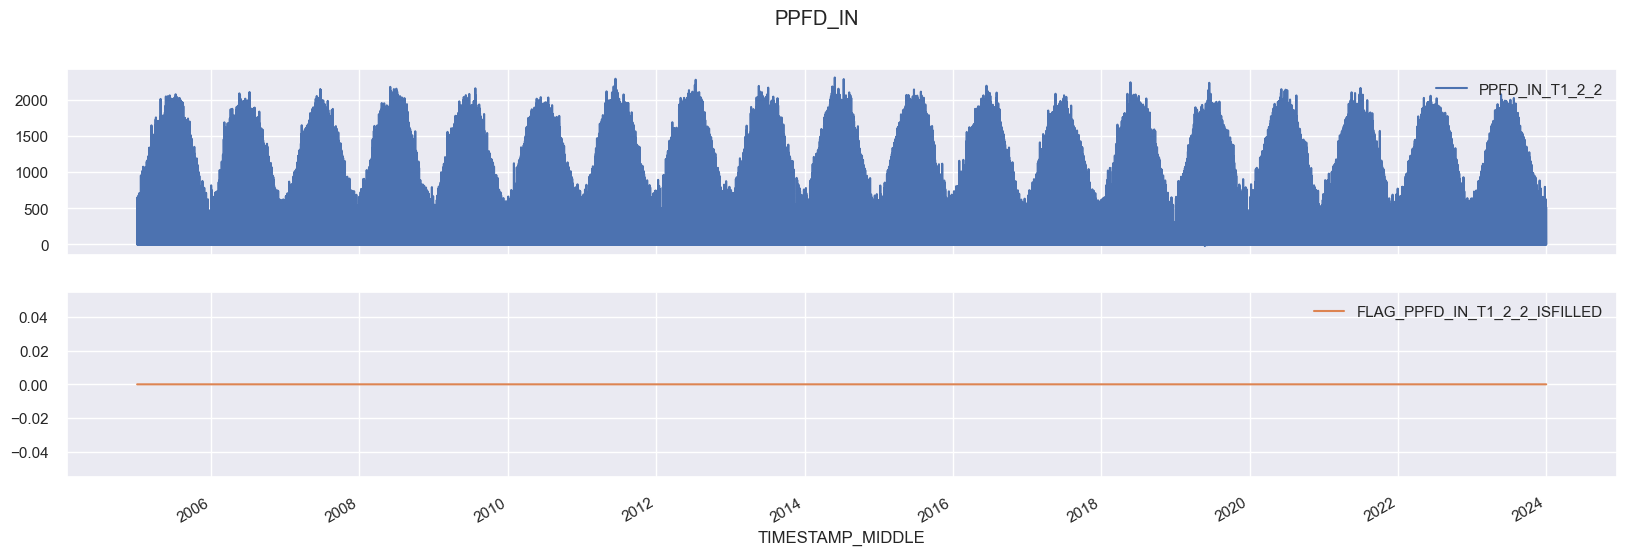

In [95]:
title = "PPFD_IN"
data_simple_2005_2023[['PPFD_IN_T1_2_2', 'FLAG_PPFD_IN_T1_2_2_ISFILLED']].plot(x_compat=True, title=title, subplots=True, figsize=(20, 6));

</br>

## Calculate VPD (kPa)

In [96]:
from diive.pkgs.createvar.vpd import calc_vpd_from_ta_rh

In [97]:
vpd = calc_vpd_from_ta_rh(df=data_simple_2005_2023, rh_col='RH_T1_2_1', ta_col='TA_T1_2_1')
vpd

TIMESTAMP_MIDDLE
2005-01-01 00:15:00    0.099893
2005-01-01 00:45:00    0.097606
2005-01-01 01:15:00    0.091683
2005-01-01 01:45:00    0.071157
2005-01-01 02:15:00    0.058333
                         ...   
2023-12-31 21:45:00    0.003675
2023-12-31 22:15:00    0.007970
2023-12-31 22:45:00    0.017429
2023-12-31 23:15:00    0.020611
2023-12-31 23:45:00    0.024959
Freq: 30min, Name: VPD, Length: 333072, dtype: float64

In [98]:
data_simple_2005_2023['VPD_T1_2_1'] = vpd

In [99]:
_df = pd.DataFrame()
_df['VPD_T1_2_1'] = data_simple_2005_2023[['VPD_T1_2_1']].copy()
_df['SW_IN_T1_2_1'] = data_simple_2005_2023[['SW_IN_T1_2_1']].copy()
_df['TA_T1_2_1'] = data_simple_2005_2023[['TA_T1_2_1']].copy()
_df

VPD_T1_2_1  SW_IN_T1_2_1  TA_T1_2_1
TIMESTAMP_MIDDLE                                        
2005-01-01 00:15:00    0.099893           0.0   1.566667
2005-01-01 00:45:00    0.097606           0.0   1.533333
2005-01-01 01:15:00    0.091683           0.0   1.566667
2005-01-01 01:45:00    0.071157           0.0   1.566667
2005-01-01 02:15:00    0.058333           0.0   1.500000
...                         ...           ...        ...
2023-12-31 21:45:00    0.003675           0.0   1.540578
2023-12-31 22:15:00    0.007970           0.0   2.051889
2023-12-31 22:45:00    0.017429           0.0   2.223067
2023-12-31 23:15:00    0.020611           0.0   2.206628
2023-12-31 23:45:00    0.024959           0.0   2.298628

[333072 rows x 3 columns]

In [101]:
_df['VPD_T1_2_1'].isnull().sum()

np.int64(169)

### Fill

In [102]:
xgb = XGBoostTS(
    input_df=_df,
    target_col='VPD_T1_2_1',
    perm_n_repeats=10,
    include_timestamp_as_features=True,
    add_continuous_record_number=True,
    n_estimators=1000,
    random_state=42,
    early_stopping_rounds=50,
    n_jobs=-1
)


Adding new data columns ...
++ Added new columns with timestamp info: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 
++ Added new column .RECORDNUMBER with record numbers from 1 to 333072.


In [103]:
xgb.reduce_features()
xgb.report_feature_reduction()


Feature reduction based on permutation importance ...
[0]	validation_0-rmse:0.38862	validation_1-rmse:0.38862
[1]	validation_0-rmse:0.30115	validation_1-rmse:0.30115
[2]	validation_0-rmse:0.24478	validation_1-rmse:0.24478
[3]	validation_0-rmse:0.21043	validation_1-rmse:0.21043
[4]	validation_0-rmse:0.18885	validation_1-rmse:0.18885
[5]	validation_0-rmse:0.17562	validation_1-rmse:0.17562
[6]	validation_0-rmse:0.16742	validation_1-rmse:0.16742
[7]	validation_0-rmse:0.16203	validation_1-rmse:0.16203
[8]	validation_0-rmse:0.15846	validation_1-rmse:0.15846
[9]	validation_0-rmse:0.15499	validation_1-rmse:0.15499
[10]	validation_0-rmse:0.15235	validation_1-rmse:0.15235
[11]	validation_0-rmse:0.15036	validation_1-rmse:0.15036
[12]	validation_0-rmse:0.14875	validation_1-rmse:0.14875
[13]	validation_0-rmse:0.14761	validation_1-rmse:0.14761
[14]	validation_0-rmse:0.14675	validation_1-rmse:0.14675
[15]	validation_0-rmse:0.14558	validation_1-rmse:0.14558
[16]	validation_0-rmse:0.14465	validation_1

In [104]:
xgb.trainmodel(showplot_scores=False, showplot_importance=False)
xgb.report_traintest()


Training final model ...
>>> Training model <class 'xgboost.sklearn.XGBRegressor'> based on data between 2005-01-01 00:45:00 and 2023-12-31 23:15:00 ...
>>> Fitting model to training data ...
[0]	validation_0-rmse:0.38862	validation_1-rmse:0.39247
[1]	validation_0-rmse:0.30115	validation_1-rmse:0.30384
[2]	validation_0-rmse:0.24478	validation_1-rmse:0.24720
[3]	validation_0-rmse:0.21043	validation_1-rmse:0.21274
[4]	validation_0-rmse:0.18885	validation_1-rmse:0.19124
[5]	validation_0-rmse:0.17569	validation_1-rmse:0.17829
[6]	validation_0-rmse:0.16749	validation_1-rmse:0.17016
[7]	validation_0-rmse:0.16205	validation_1-rmse:0.16469
[8]	validation_0-rmse:0.15846	validation_1-rmse:0.16131
[9]	validation_0-rmse:0.15496	validation_1-rmse:0.15784
[10]	validation_0-rmse:0.15232	validation_1-rmse:0.15531
[11]	validation_0-rmse:0.15036	validation_1-rmse:0.15324
[12]	validation_0-rmse:0.14842	validation_1-rmse:0.15136
[13]	validation_0-rmse:0.14719	validation_1-rmse:0.15024
[14]	validation_0-r

In [105]:
xgb.fillgaps(showplot_scores=False, showplot_importance=False)
xgb.report_gapfilling()


Gap-filling using final model ...
>>> Using final model on all data to predict target VPD_T1_2_1 ...
>>> Using final model on all data to calculate permutation importance ...
>>> Calculating prediction scores based on all data predicting VPD_T1_2_1 ...
>>> Predicting target VPD_T1_2_1 where all features are available ... predicted 333072 records.
>>> Collecting results for final model ...
>>> Filling 169 missing records in target with predictions from final model ...
>>> Storing gap-filled time series in variable VPD_T1_2_1_gfXG ...
>>> Restoring original timestamp in results ...
>>> Combining predictions from full model and fallback model ...

GAP-FILLING RESULTS

Model scores and feature importances were calculated from high-quality predicted targets (169 values, VPD_T1_2_1_gfXG where flag=1) in comparison to observed targets (332903 values, VPD_T1_2_1).

## TARGET
- first timestamp:  2005-01-01 00:15:00
- last timestamp:  2023-12-31 23:45:00
- potential number of values: 333072 val

### Results

In [106]:
results = xgb.gapfilling_df_
results

.PREDICTIONS_FULLMODEL  VPD_T1_2_1  .GAP_PREDICTIONS  FLAG_VPD_T1_2_1_gfXG_ISFILLED  VPD_T1_2_1_gfXG .PREDICTIONS_FALLBACK  .GAPFILLED_CUMULATIVE  .PREDICTIONS
TIMESTAMP_MIDDLE                                                                                                                                                                    
2005-01-01 00:15:00                0.079794    0.099893               NaN                              0         0.099893                  None               0.099893      0.079794
2005-01-01 00:45:00                0.079794    0.097606               NaN                              0         0.097606                  None               0.197499      0.079794
2005-01-01 01:15:00                0.065812    0.091683               NaN                              0         0.091683                  None               0.289182      0.065812
2005-01-01 01:45:00                0.065812    0.071157               NaN                              0         0.071157                  None               0.360339      0.065812
2005-01-01 02:15:00                0.059568    0.058333               NaN                              0         0.058333                  None               0.418672      0.059568
...                                     ...         ...               ...                            ...              ...                   ...                    ...           ...
2023-12-31 21:45:00               -0.002622    0.003675               NaN                              0         0.003675                  None          104683.078372     -0.002622
2023-12-31 22:15:00                0.014771    0.007970               NaN                              0         0.007970                  None          104683.086342      0.014771
2023-12-31 22:45:00                0.008453    0.017429               NaN                              0         0.017429                  None          104683.103771      0.008453
2023-12-31 23:15:00                0.011330    0.020611               NaN                              0         0.020611                  None          104683.124382      0.011330
2023-12-31 23:45:00                0.010841    0.024959               NaN                              0         0.024959                  None          104683.149341      0.010841

[333072 rows x 8 columns]

### Add to data

In [107]:
# Combine data
data_simple_2005_2023['VPD_T1_2_1'] = results['VPD_T1_2_1_gfXG'].copy()
data_simple_2005_2023['VPD_T1_2_1']

TIMESTAMP_MIDDLE
2005-01-01 00:15:00    0.099893
2005-01-01 00:45:00    0.097606
2005-01-01 01:15:00    0.091683
2005-01-01 01:45:00    0.071157
2005-01-01 02:15:00    0.058333
                         ...   
2023-12-31 21:45:00    0.003675
2023-12-31 22:15:00    0.007970
2023-12-31 22:45:00    0.017429
2023-12-31 23:15:00    0.020611
2023-12-31 23:45:00    0.024959
Freq: 30min, Name: VPD_T1_2_1, Length: 333072, dtype: float64

In [108]:
# Combine flags not necessary, because PPFD was not gapfilled before
data_simple_2005_2023['FLAG_VPD_T1_2_1_ISFILLED'] = results['FLAG_VPD_T1_2_1_gfXG_ISFILLED'].copy()
data_simple_2005_2023['FLAG_VPD_T1_2_1_ISFILLED']

TIMESTAMP_MIDDLE
2005-01-01 00:15:00    0
2005-01-01 00:45:00    0
2005-01-01 01:15:00    0
2005-01-01 01:45:00    0
2005-01-01 02:15:00    0
                      ..
2023-12-31 21:45:00    0
2023-12-31 22:15:00    0
2023-12-31 22:45:00    0
2023-12-31 23:15:00    0
2023-12-31 23:45:00    0
Freq: 30min, Name: FLAG_VPD_T1_2_1_ISFILLED, Length: 333072, dtype: int64

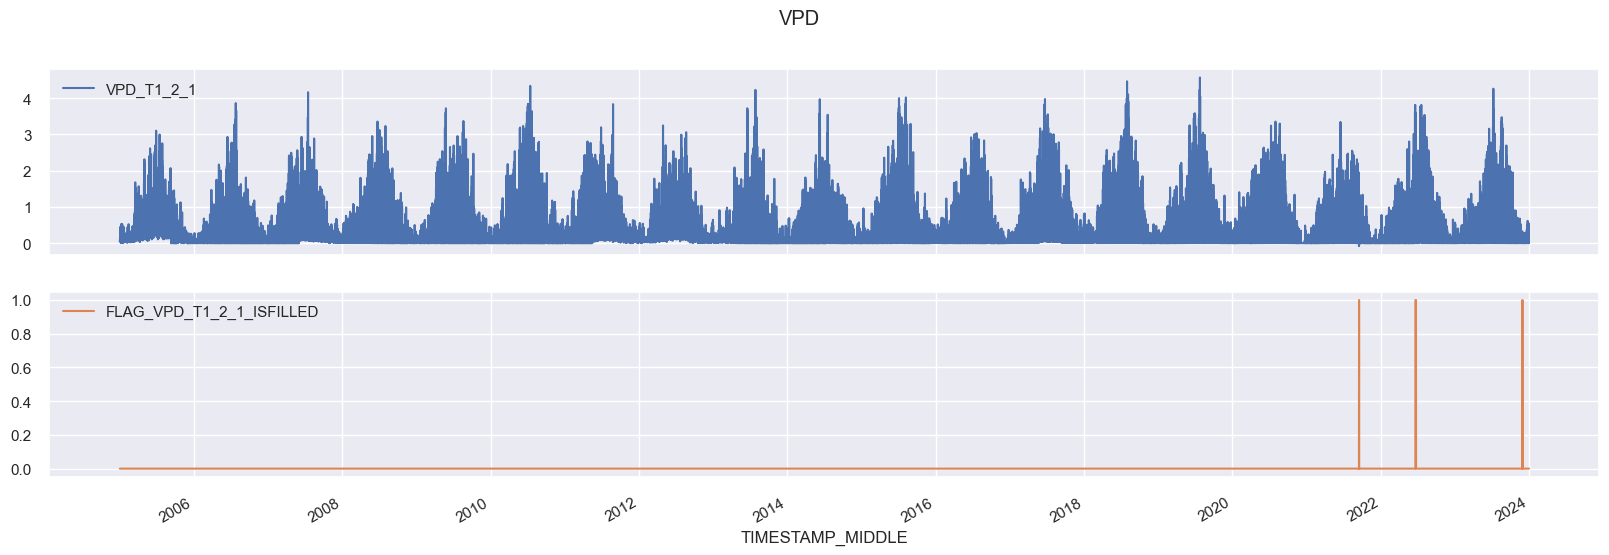

In [109]:
title = "VPD"
data_simple_2005_2023[['VPD_T1_2_1', 'FLAG_VPD_T1_2_1_ISFILLED']].plot(x_compat=True, title=title, subplots=True, figsize=(20, 6));

</br>

# **Plots**

In [110]:
_plot_df = data_simple_2005_2023.copy()
_plot_df = _plot_df.replace(-9999, np.nan)

## Time series plot

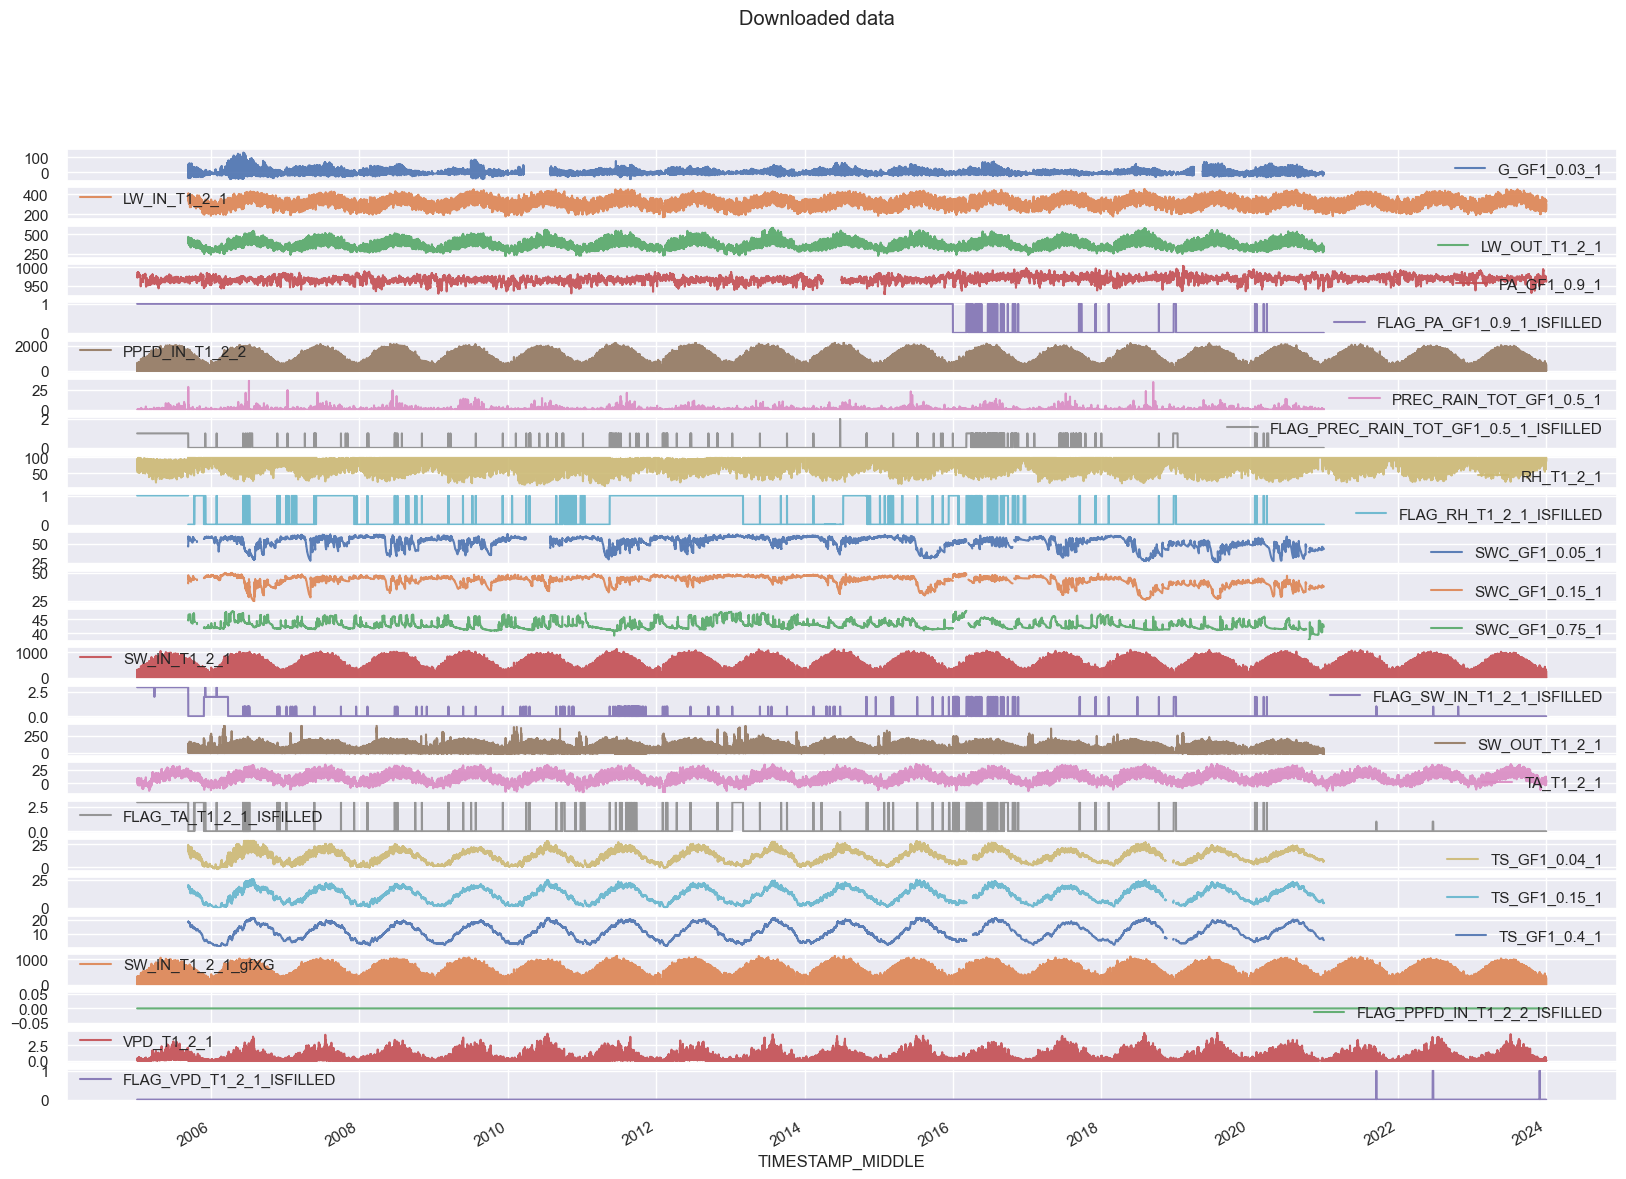

In [111]:
_plot_df.plot(subplots=True, figsize=(20, 14), title="Downloaded data", alpha=.9, x_compat=True);

## Heatmaps

F:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\core\plotting\heatmap_base.py:190: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(facecolor='white', figsize=self.figsize)


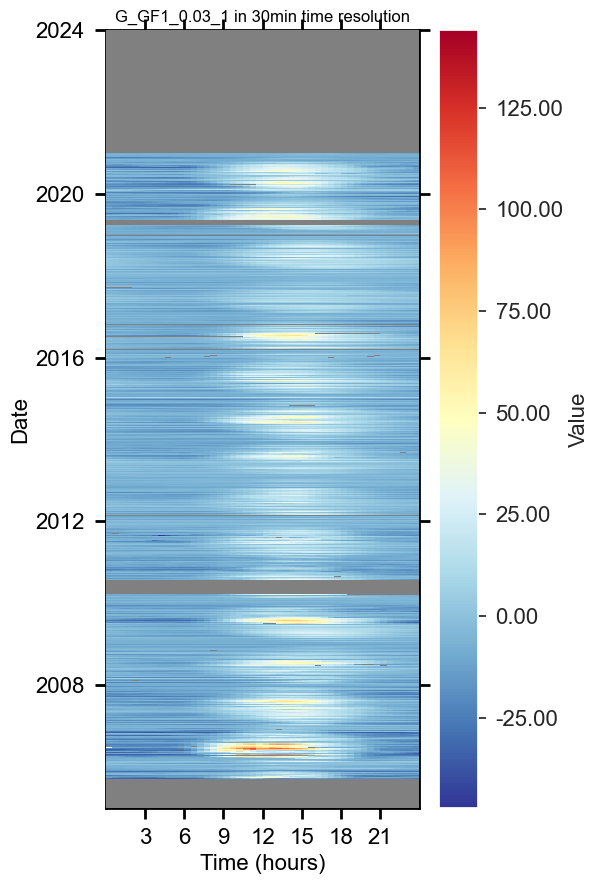

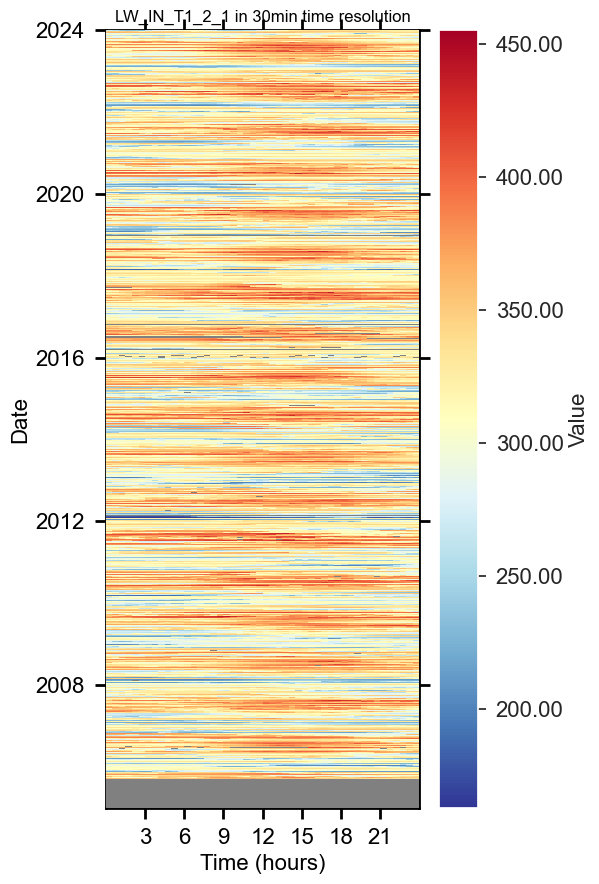

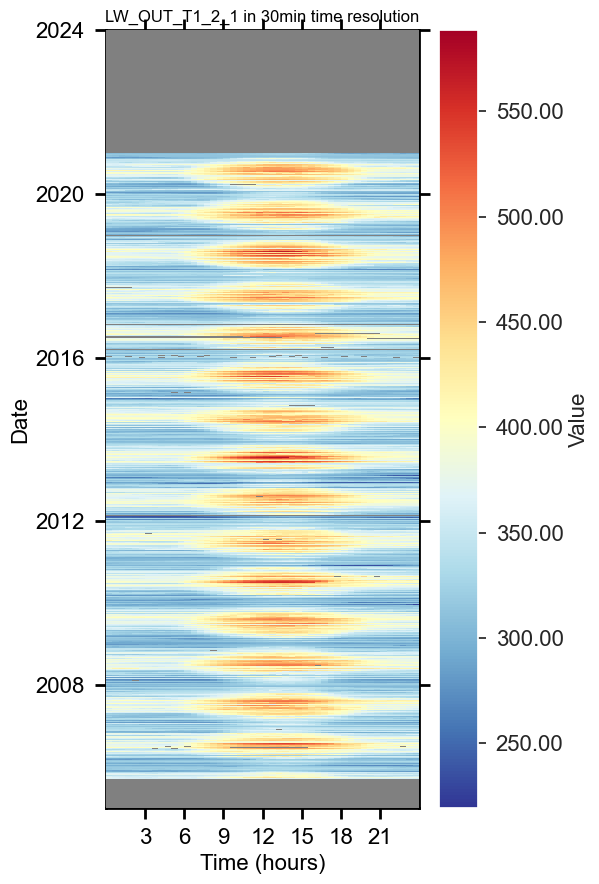

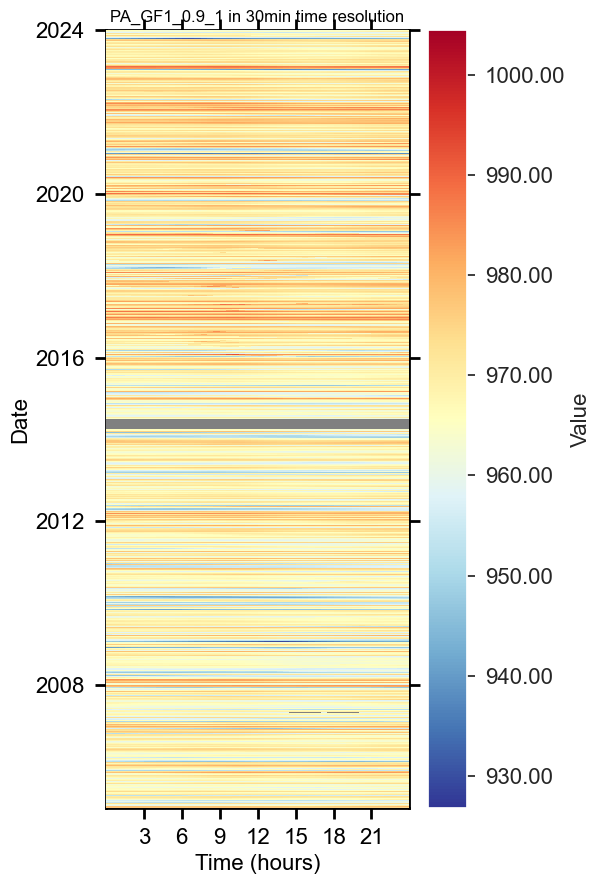

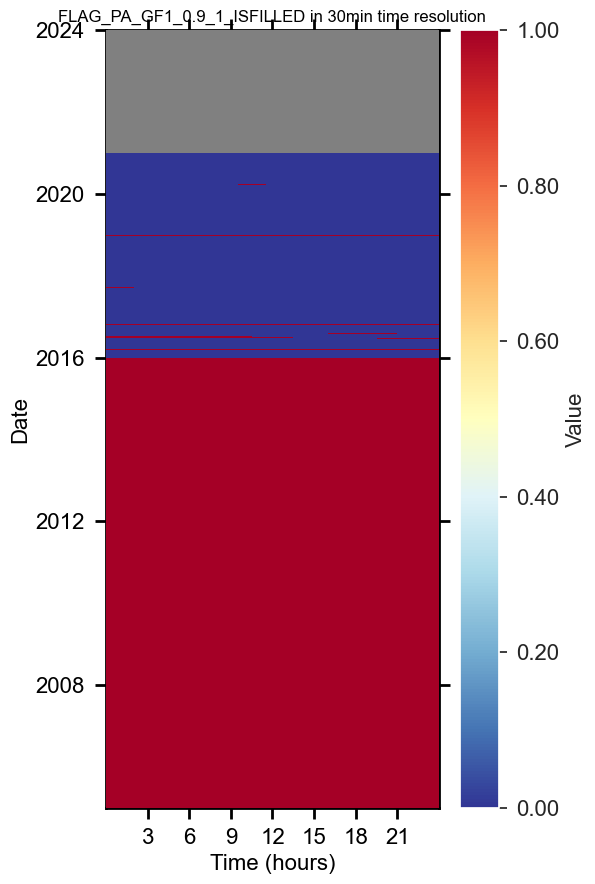

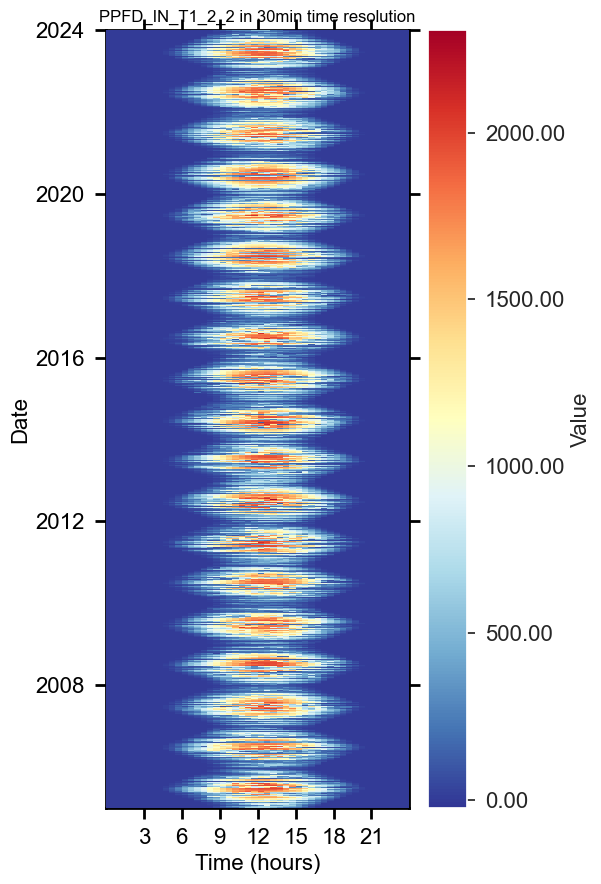

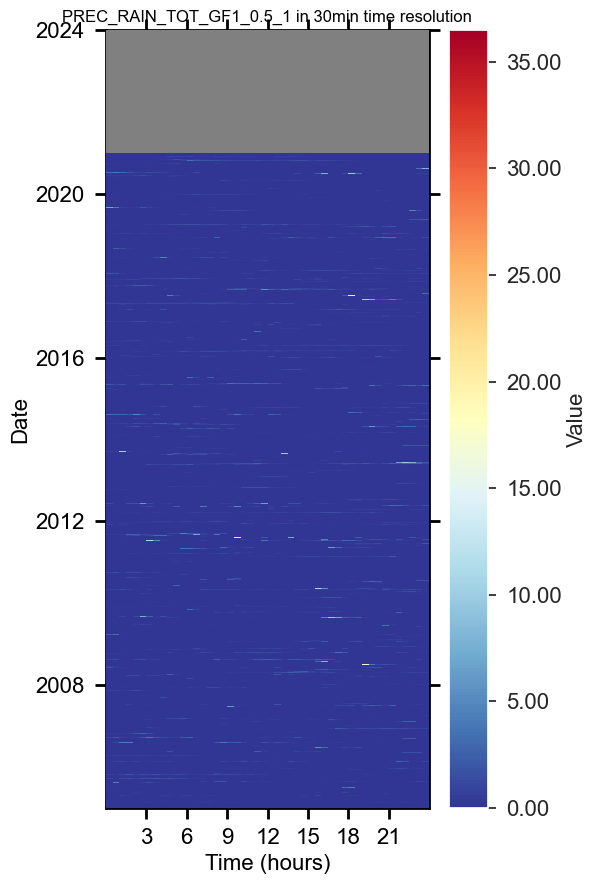

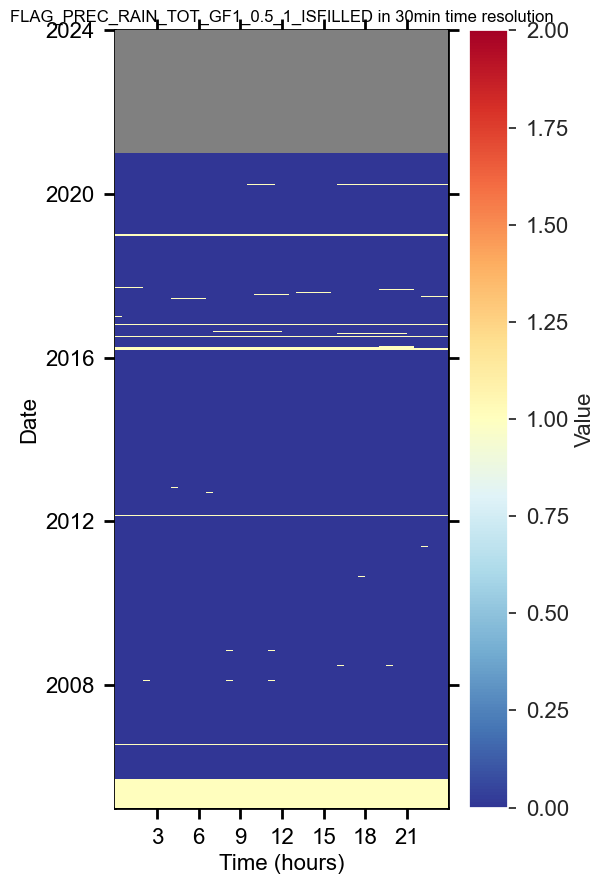

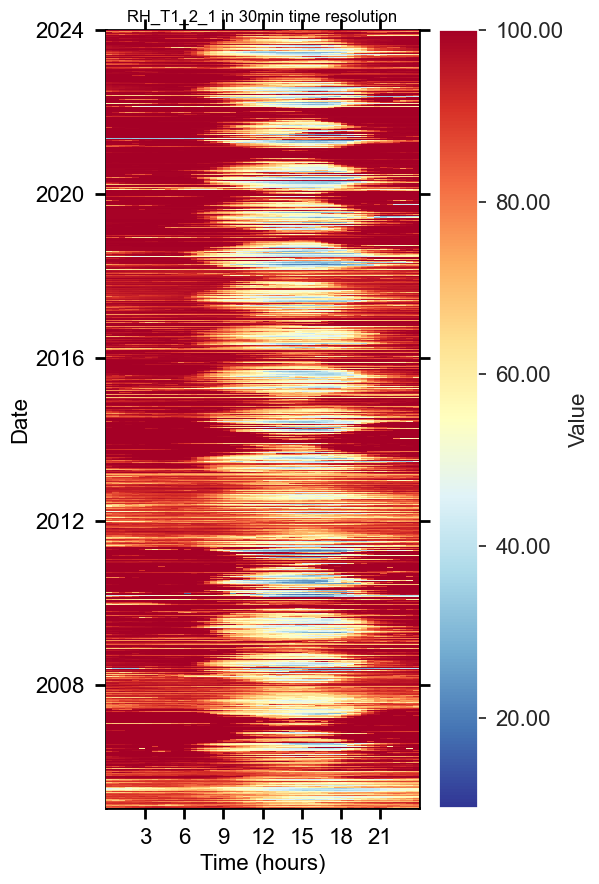

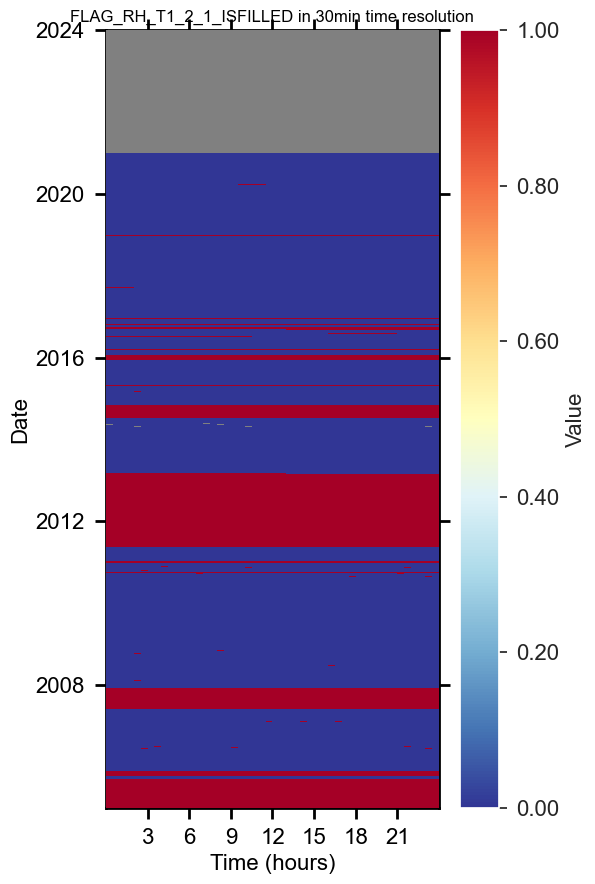

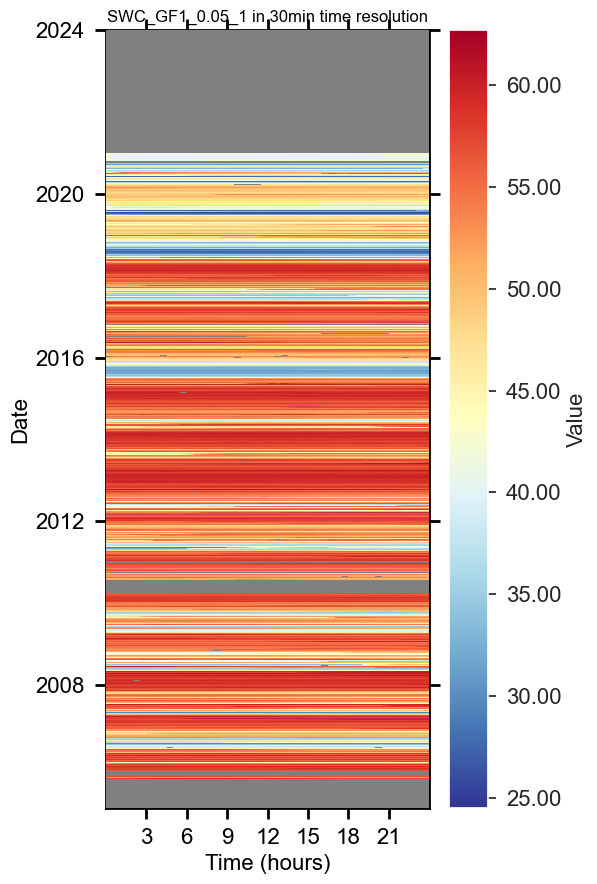

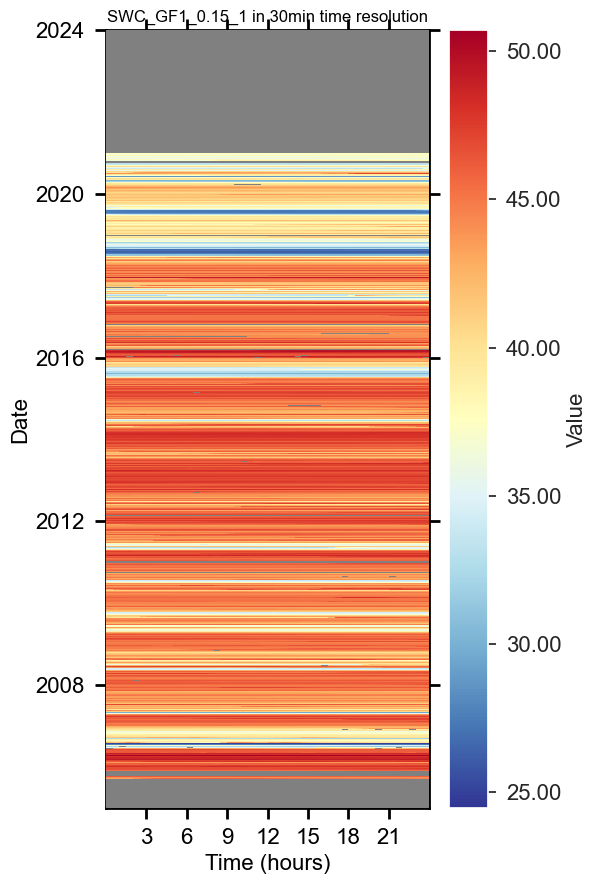

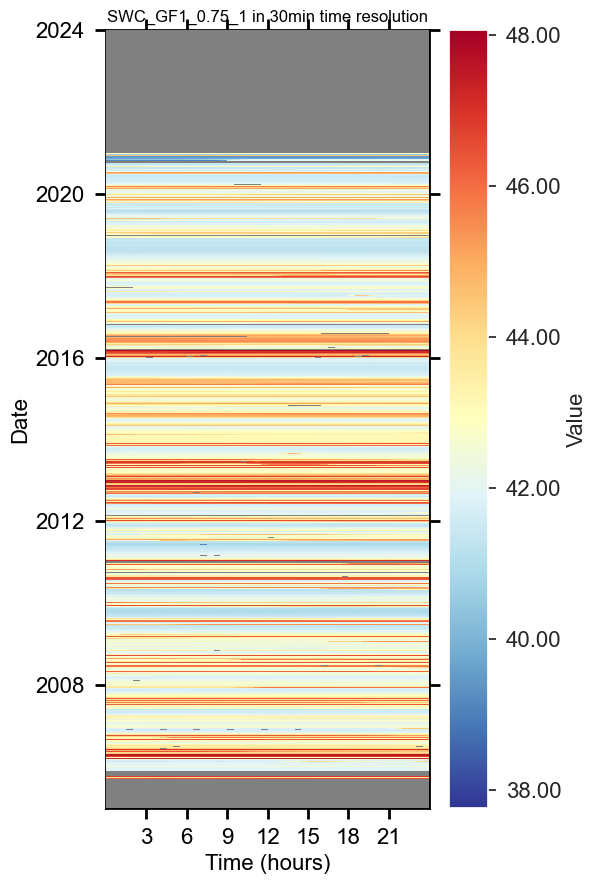

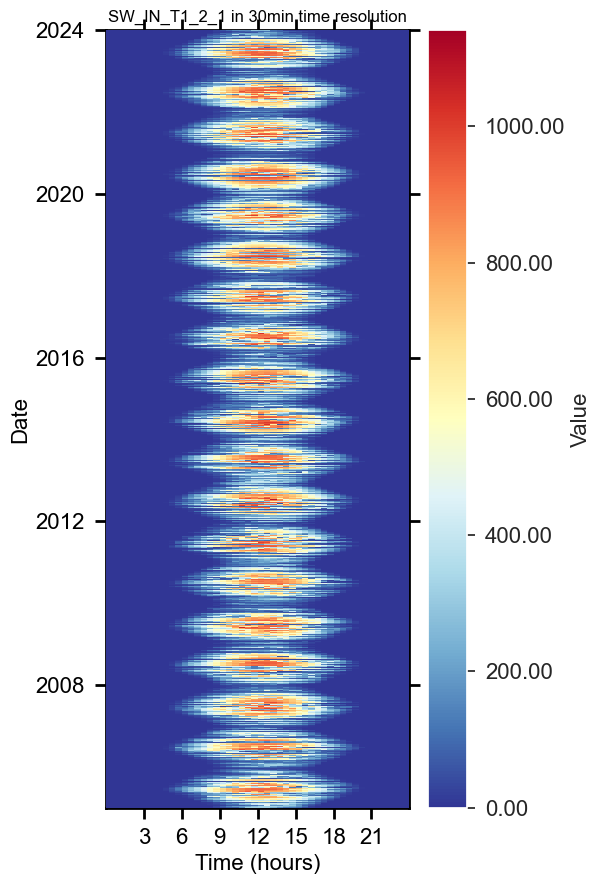

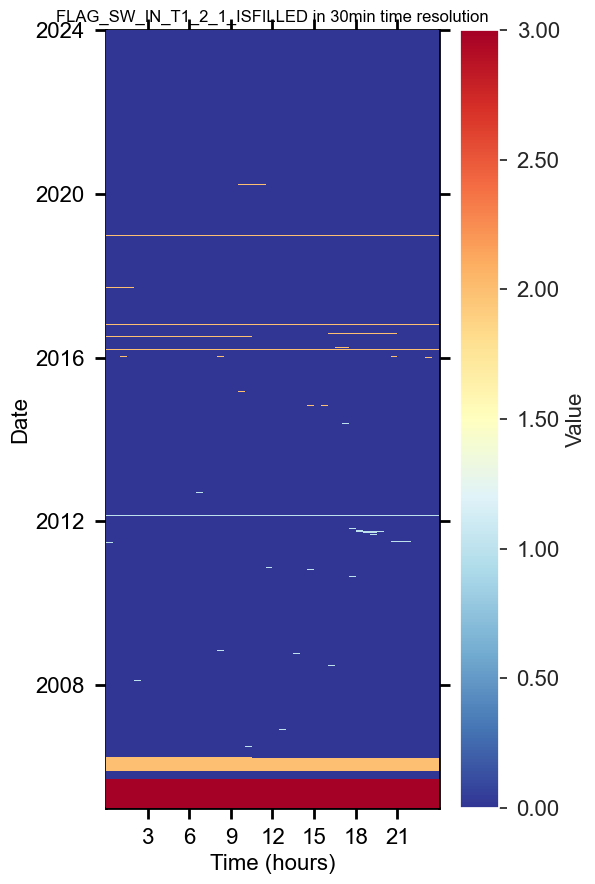

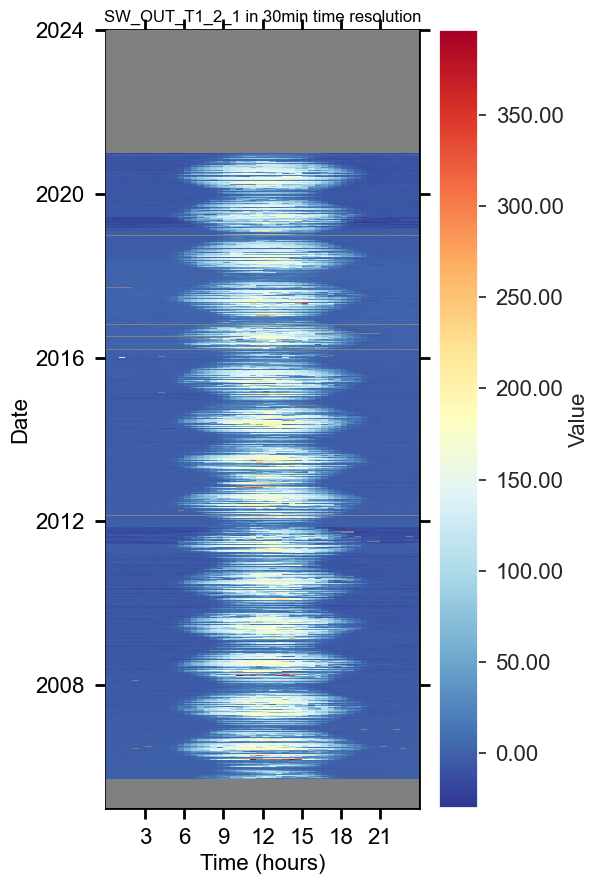

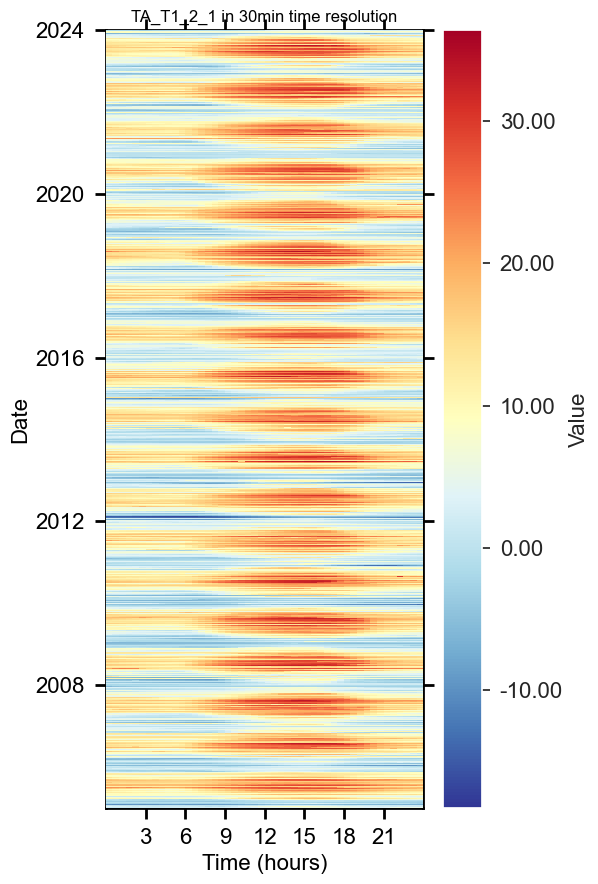

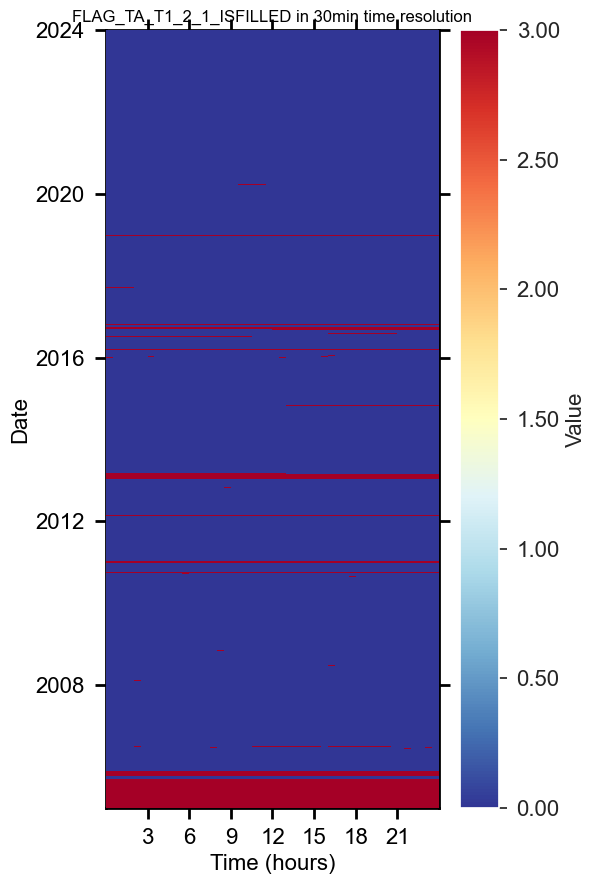

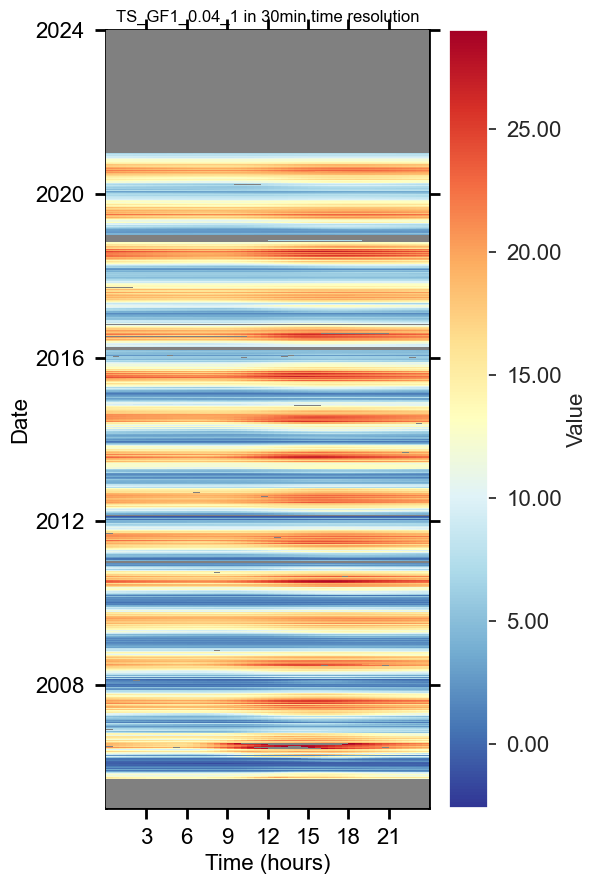

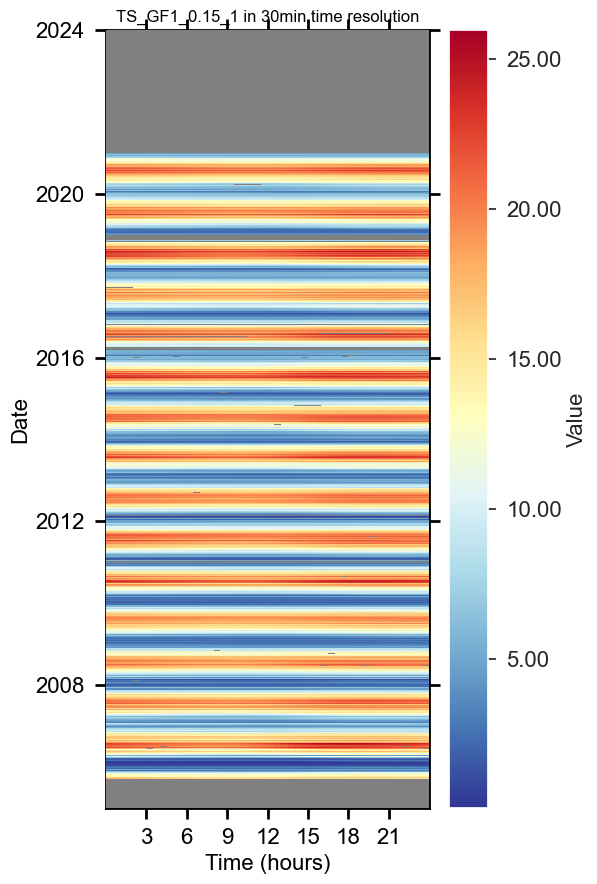

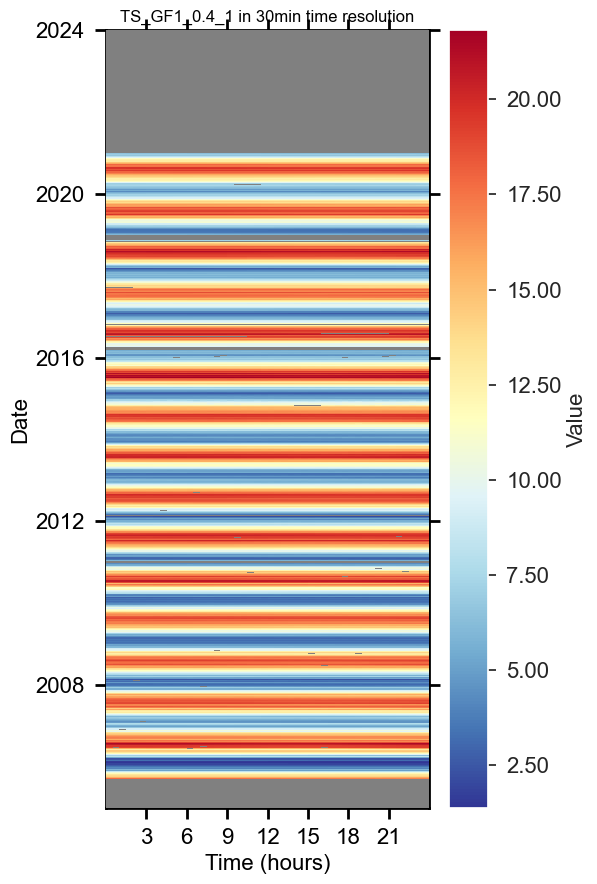

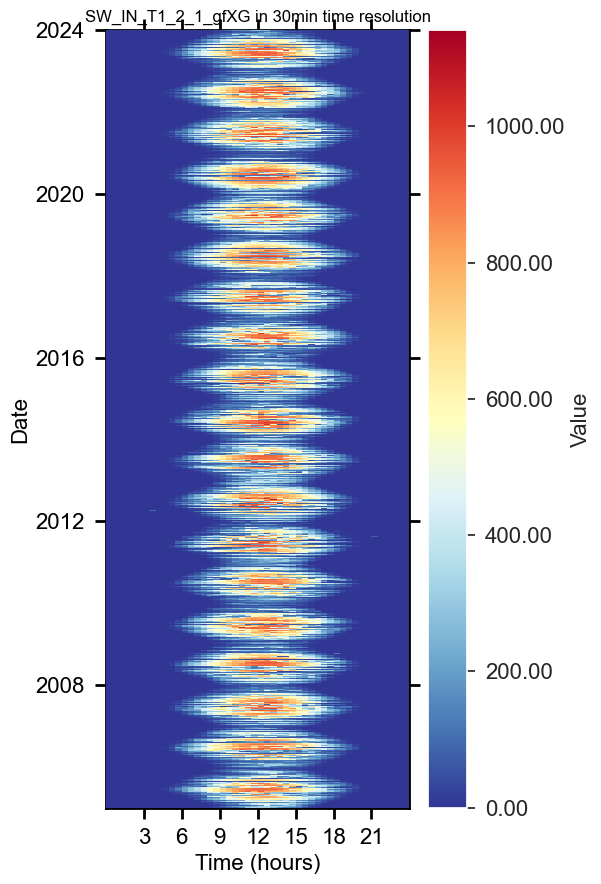

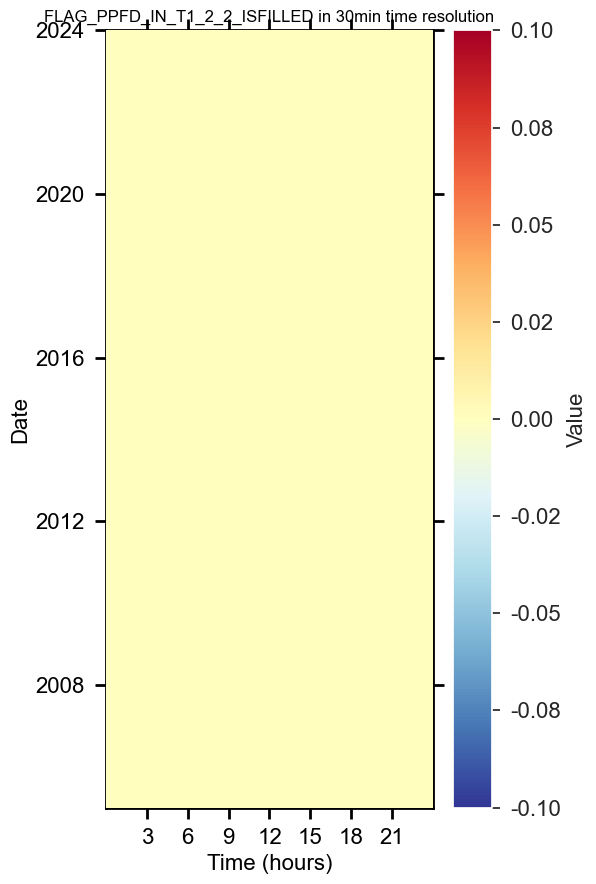

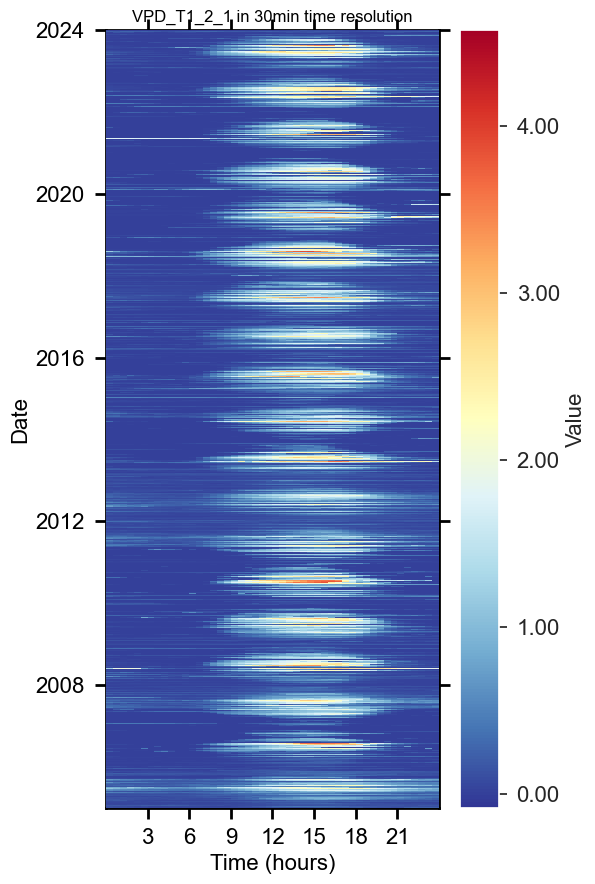

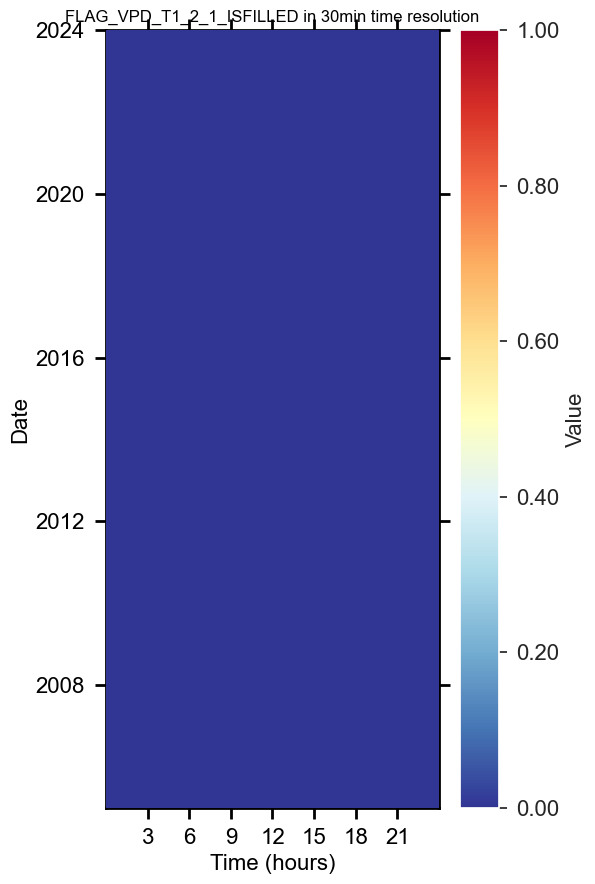

In [112]:
for col in _plot_df.columns:
    series = _plot_df[col]
    series.name = col
    HeatmapDateTime(series, figsize=(6, 9)).show()

</br>

# **Stats**

In [114]:
data_simple_2005_2023.describe().T

count        mean         std         min         25%         50%         75%          max
G_GF1_0.03_1                           257233.0   -1.294757   13.078049  -47.055000   -8.839500   -4.027900    3.322900   144.000000
LW_IN_T1_2_1                           317075.0  322.970987   44.268154  162.974472  295.586159  325.623444  354.521115   454.941700
LW_OUT_T1_2_1                          264726.0  363.862656   49.620005  219.459778  325.215393  357.583692  393.994850   588.454834
PA_GF1_0.9_1                           328410.0  967.955490    8.018778  926.800000  963.400000  968.343933  973.026568  1004.485000
FLAG_PA_GF1_0.9_1_ISFILLED             280512.0    0.697350    0.459406    0.000000    0.000000    1.000000    1.000000     1.000000
PPFD_IN_T1_2_2                         333072.0  282.390358  468.510861  -23.804630    0.000000    0.336660  372.637489  2306.300049
PREC_RAIN_TOT_GF1_0.5_1                280512.0    0.064690    0.408662    0.000000    0.000000    0.000000    0.000000    36.480904
FLAG_PREC_RAIN_TOT_GF1_0.5_1_ISFILLED  280512.0    0.063266    0.243457    0.000000    0.000000    0.000000    0.000000     2.000000
RH_T1_2_1                              332903.0   84.302871   18.246219    9.561100   73.051190   91.903720   99.717001   100.000000
FLAG_RH_T1_2_1_ISFILLED                280439.0    0.242998    0.428894    0.000000    0.000000    0.000000    0.000000     1.000000
SWC_GF1_0.05_1                         255743.0   50.799695    7.900669   24.511940   47.020676   53.084404   56.925919    62.706470
SWC_GF1_0.15_1                         261403.0   42.715561    4.602187   24.468729   40.653645   44.082874   45.981319    50.708080
SWC_GF1_0.75_1                         261394.0   43.008481    1.596751   37.764030   41.844761   42.524414   43.705841    48.056732
SW_IN_T1_2_1                           333072.0  142.915491  236.348552    0.000000    0.000000    0.000000  189.542057  1140.900024
FLAG_SW_IN_T1_2_1_ISFILLED             333072.0    0.158557    0.631603    0.000000    0.000000    0.000000    0.000000     3.000000
SW_OUT_T1_2_1                          265645.0   26.672217   49.826913  -29.716660   -3.722600    0.698370   39.070100   396.149994
TA_T1_2_1                              333072.0    9.955558    8.456280  -18.246000    3.240275    9.660700   15.962961    36.348891
FLAG_TA_T1_2_1_ISFILLED                333072.0    0.200344    0.748248    0.000000    0.000000    0.000000    0.000000     3.000000
TS_GF1_0.04_1                          261097.0   11.635724    6.528476   -2.576900    5.872834   11.853000   17.216000    29.000000
TS_GF1_0.15_1                          261812.0   11.692454    6.248735    0.045730    5.830100   11.827865   17.303924    25.957001
TS_GF1_0.4_1                           261914.0   11.546517    5.482197    1.378100    6.261362   11.589000   16.733999    21.813999
SW_IN_T1_2_1_gfXG                      333072.0  143.061851  236.264219   -0.158850    0.000000    3.071409  189.579588  1140.900024
FLAG_PPFD_IN_T1_2_2_ISFILLED           333072.0    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000     0.000000
VPD_T1_2_1                             333072.0    0.314296    0.522228   -0.082470    0.002796    0.081574    0.377409     4.574110
FLAG_VPD_T1_2_1_ISFILLED               333072.0    0.000507    0.022520    0.000000    0.000000    0.000000    0.000000     1.000000

</br>

# Keep 7 meteo variables

In [116]:
keepcols = [
    'LW_IN_T1_2_1',
    'PA_GF1_0.9_1',
    'FLAG_PA_GF1_0.9_1_ISFILLED',
    'PPFD_IN_T1_2_2',
    'FLAG_PPFD_IN_T1_2_2_ISFILLED',
    'VPD_T1_2_1',
    'FLAG_VPD_T1_2_1_ISFILLED',
    'SW_IN_T1_2_1',
    'FLAG_SW_IN_T1_2_1_ISFILLED',
    'TA_T1_2_1',
    'FLAG_TA_T1_2_1_ISFILLED',
    'RH_T1_2_1',
    'FLAG_RH_T1_2_1_ISFILLED'    
]
outdf = data_simple_2005_2023[keepcols].copy()
outdf

LW_IN_T1_2_1  PA_GF1_0.9_1  FLAG_PA_GF1_0.9_1_ISFILLED  PPFD_IN_T1_2_2  FLAG_PPFD_IN_T1_2_2_ISFILLED  VPD_T1_2_1  FLAG_VPD_T1_2_1_ISFILLED  SW_IN_T1_2_1  FLAG_SW_IN_T1_2_1_ISFILLED  TA_T1_2_1  FLAG_TA_T1_2_1_ISFILLED  RH_T1_2_1  FLAG_RH_T1_2_1_ISFILLED
TIMESTAMP_MIDDLE                                                                                                                                                                                                                                                                 
2005-01-01 00:15:00           NaN    978.100000                         1.0             0.0                             0    0.099893                         0           0.0                         3.0   1.566667                      3.0  85.400000                      1.0
2005-01-01 00:45:00           NaN    977.933333                         1.0             0.0                             0    0.097606                         0           0.0                         3.0   1.533333                      3.0  85.700000                      1.0
2005-01-01 01:15:00           NaN    977.900000                         1.0             0.0                             0    0.091683                         0           0.0                         3.0   1.566667                      3.0  86.600000                      1.0
2005-01-01 01:45:00           NaN    977.833333                         1.0             0.0                             0    0.071157                         0           0.0                         3.0   1.566667                      3.0  89.600000                      1.0
2005-01-01 02:15:00           NaN    977.833333                         1.0             0.0                             0    0.058333                         0           0.0                         3.0   1.500000                      3.0  91.433333                      1.0
...                           ...           ...                         ...             ...                           ...         ...                       ...           ...                         ...        ...                      ...        ...                      ...
2023-12-31 21:45:00    327.407107    964.969617                         NaN             0.0                             0    0.003675                         0           0.0                         0.0   1.540578                      0.0  99.461884                      NaN
2023-12-31 22:15:00    327.958383    965.049553                         NaN             0.0                             0    0.007970                         0           0.0                         0.0   2.051889                      0.0  98.875075                      NaN
2023-12-31 22:45:00    328.605910    965.261047                         NaN             0.0                             0    0.017429                         0           0.0                         0.0   2.223067                      0.0  97.569925                      NaN
2023-12-31 23:15:00    328.278320    965.526500                         NaN             0.0                             0    0.020611                         0           0.0                         0.0   2.206628                      0.0  97.122825                      NaN
2023-12-31 23:45:00    328.591967    965.684977                         NaN             0.0                             0    0.024959                         0           0.0                         0.0   2.298628                      0.0  96.538665                      NaN

[333072 rows x 13 columns]

</br>

# **Save measured and gap-filled data to parquet**

In [118]:
OUTNAME = "16.1_CH-CHA_meteo7_gapfilled_2005-2023"
OUTPATH = r"F:\Sync\luhk_work\20 - CODING\29 - WORKBENCH\dataset_cha_fp2024_2005-2023\10_METEO\13_merge_meteo_for_analyses_2005-2023"
filepath = save_parquet(filename=OUTNAME, data=outdf, outpath=OUTPATH)
outdf.to_csv(Path(OUTPATH) / f"{OUTNAME}.csv")

Saved file F:\Sync\luhk_work\20 - CODING\29 - WORKBENCH\dataset_cha_fp2024_2005-2023\10_METEO\13_merge_meteo_for_analyses_2005-2023\16.1_CH-CHA_meteo7_gapfilled_2005-2023.parquet (0.260 seconds).


</br>

# **End of notebook**.

In [120]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

Finished. 2024-09-02 15:21:17
